# 1 Configuración del ambiente

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from IPython.display import display
from typing import List, Tuple, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from pandas.api.types import is_period_dtype
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

# 2 Carga de datos limpios

In [91]:
# Cargar los datos del dataset procesados de 01_carga_limpieza
df = pd.read_parquet(r'C:\Users\xavie\Documents\PROYECTOS\fraud-detection-ml\data\processed\01_df_limpieza.parquet')
print("Dataset cargado correctamente")
print(f"Forma del dataset: {df.shape}")

Dataset cargado correctamente
Forma del dataset: (1463837, 39)


In [92]:
df_patrones = df.copy()
df_patrones_fraudes = df_patrones[df_patrones['Fraude']== 1].copy()
df_patrones_fraudes_cnp = df_patrones_fraudes[df_patrones_fraudes['canal'] == 'CNP'].copy()



df_patrones_fraudes['mes_year'] = df_patrones_fraudes['mes_year'].astype(str)
df_patrones_fraudes['year'] = df_patrones_fraudes['year'].astype(str)
df_patrones_fraudes['mes_year'] = df_patrones_fraudes['mes_year'].astype(str)
df_patrones_fraudes['trimestre'] = df_patrones_fraudes['trimestre'].astype(str)

In [ ]:
# Filtrar datos a analizar


def filtrar_df (df, year_field, years):
    if isinstance(years, list):
        return df[df[year_field].isin(years)]
    return df[df[year_field] == years]

tiempo_analizar = ['2023','2024','2025']
columna_filtro = 'year'

df_patrones_fraudes_f = filtrar_df(df_patrones_fraudes, columna_filtro, tiempo_analizar)




## Análisis de Fraude por Nombre comercio para Tarjetas No Presente (CNP)

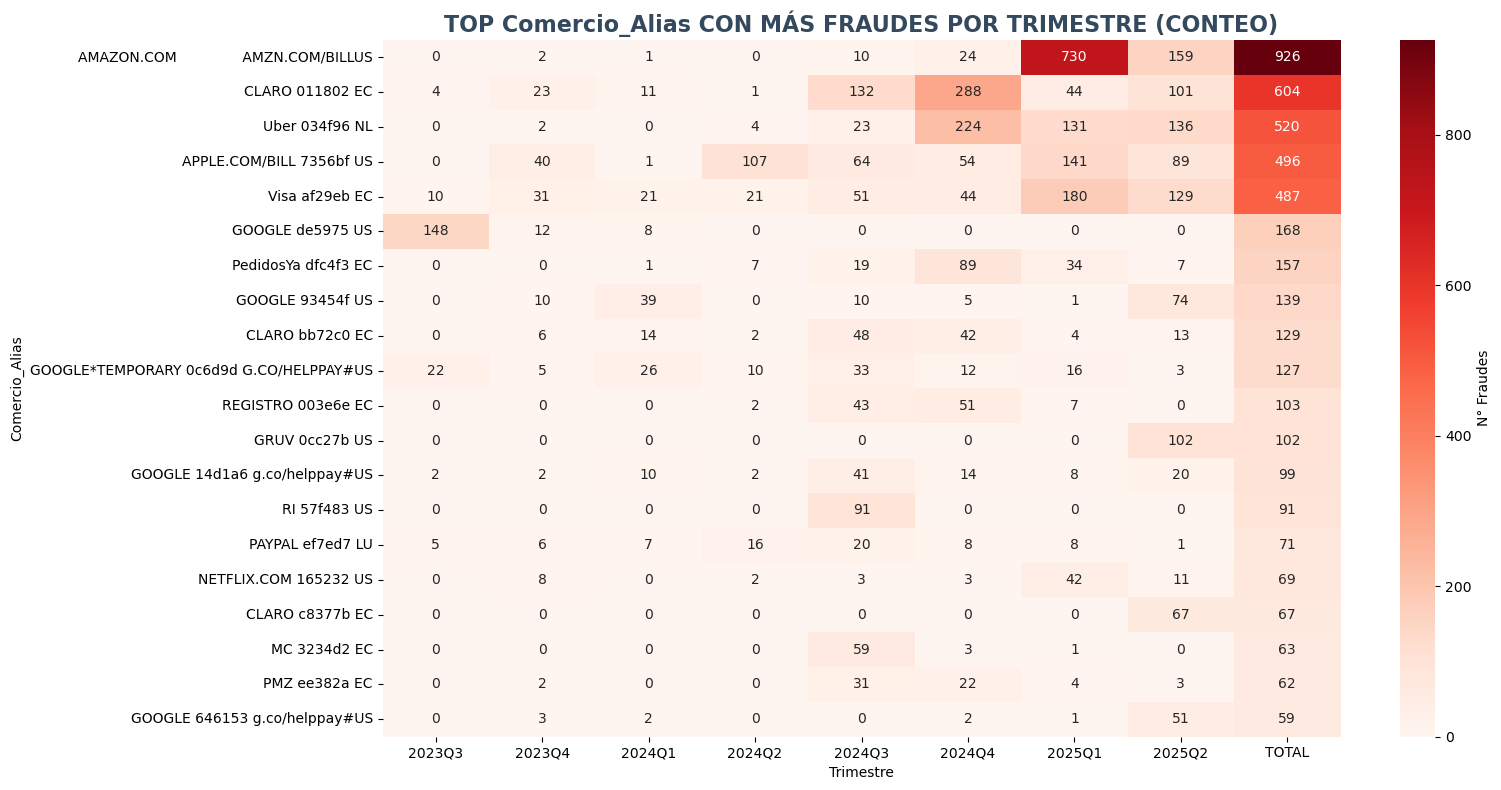

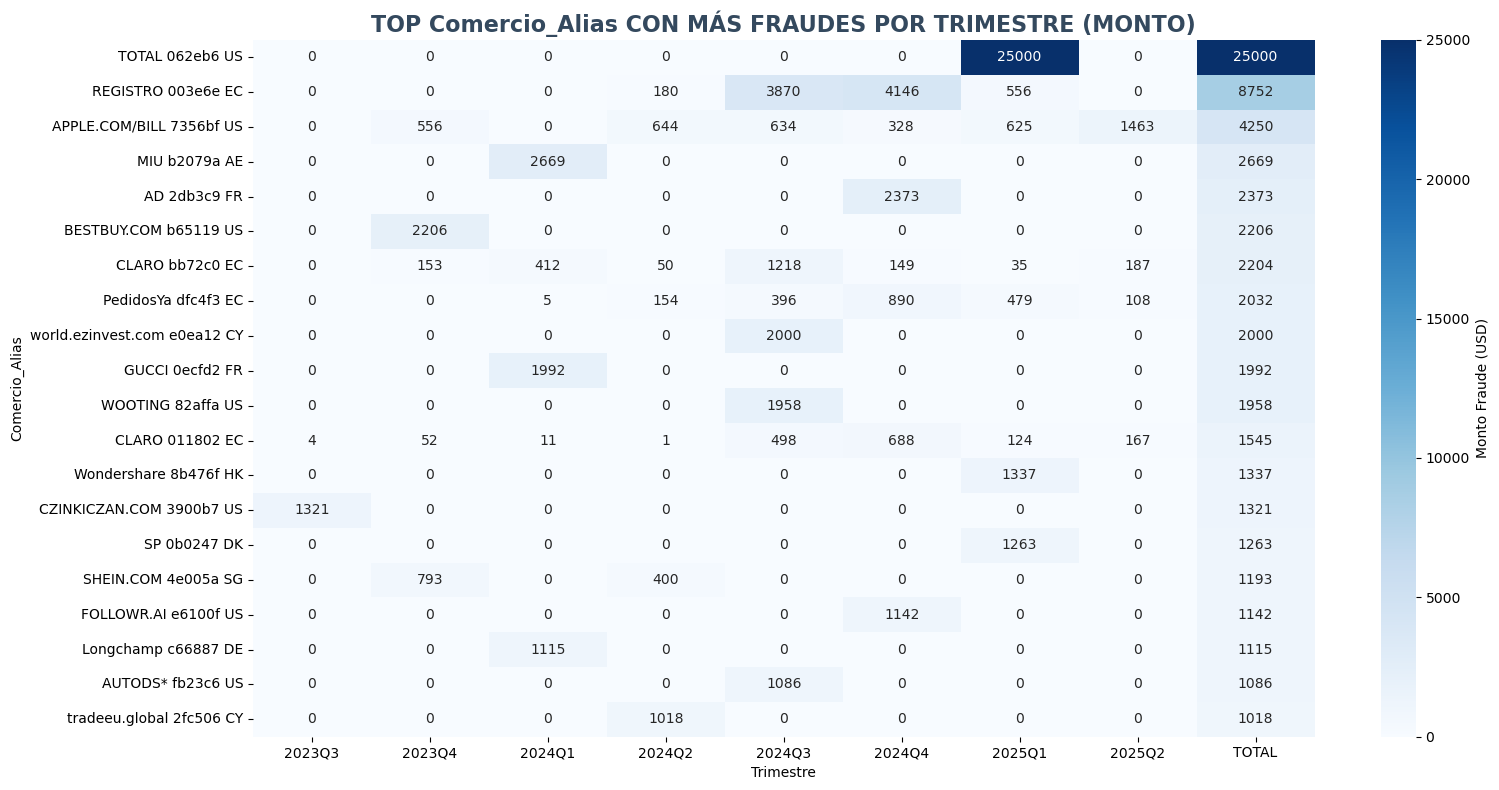

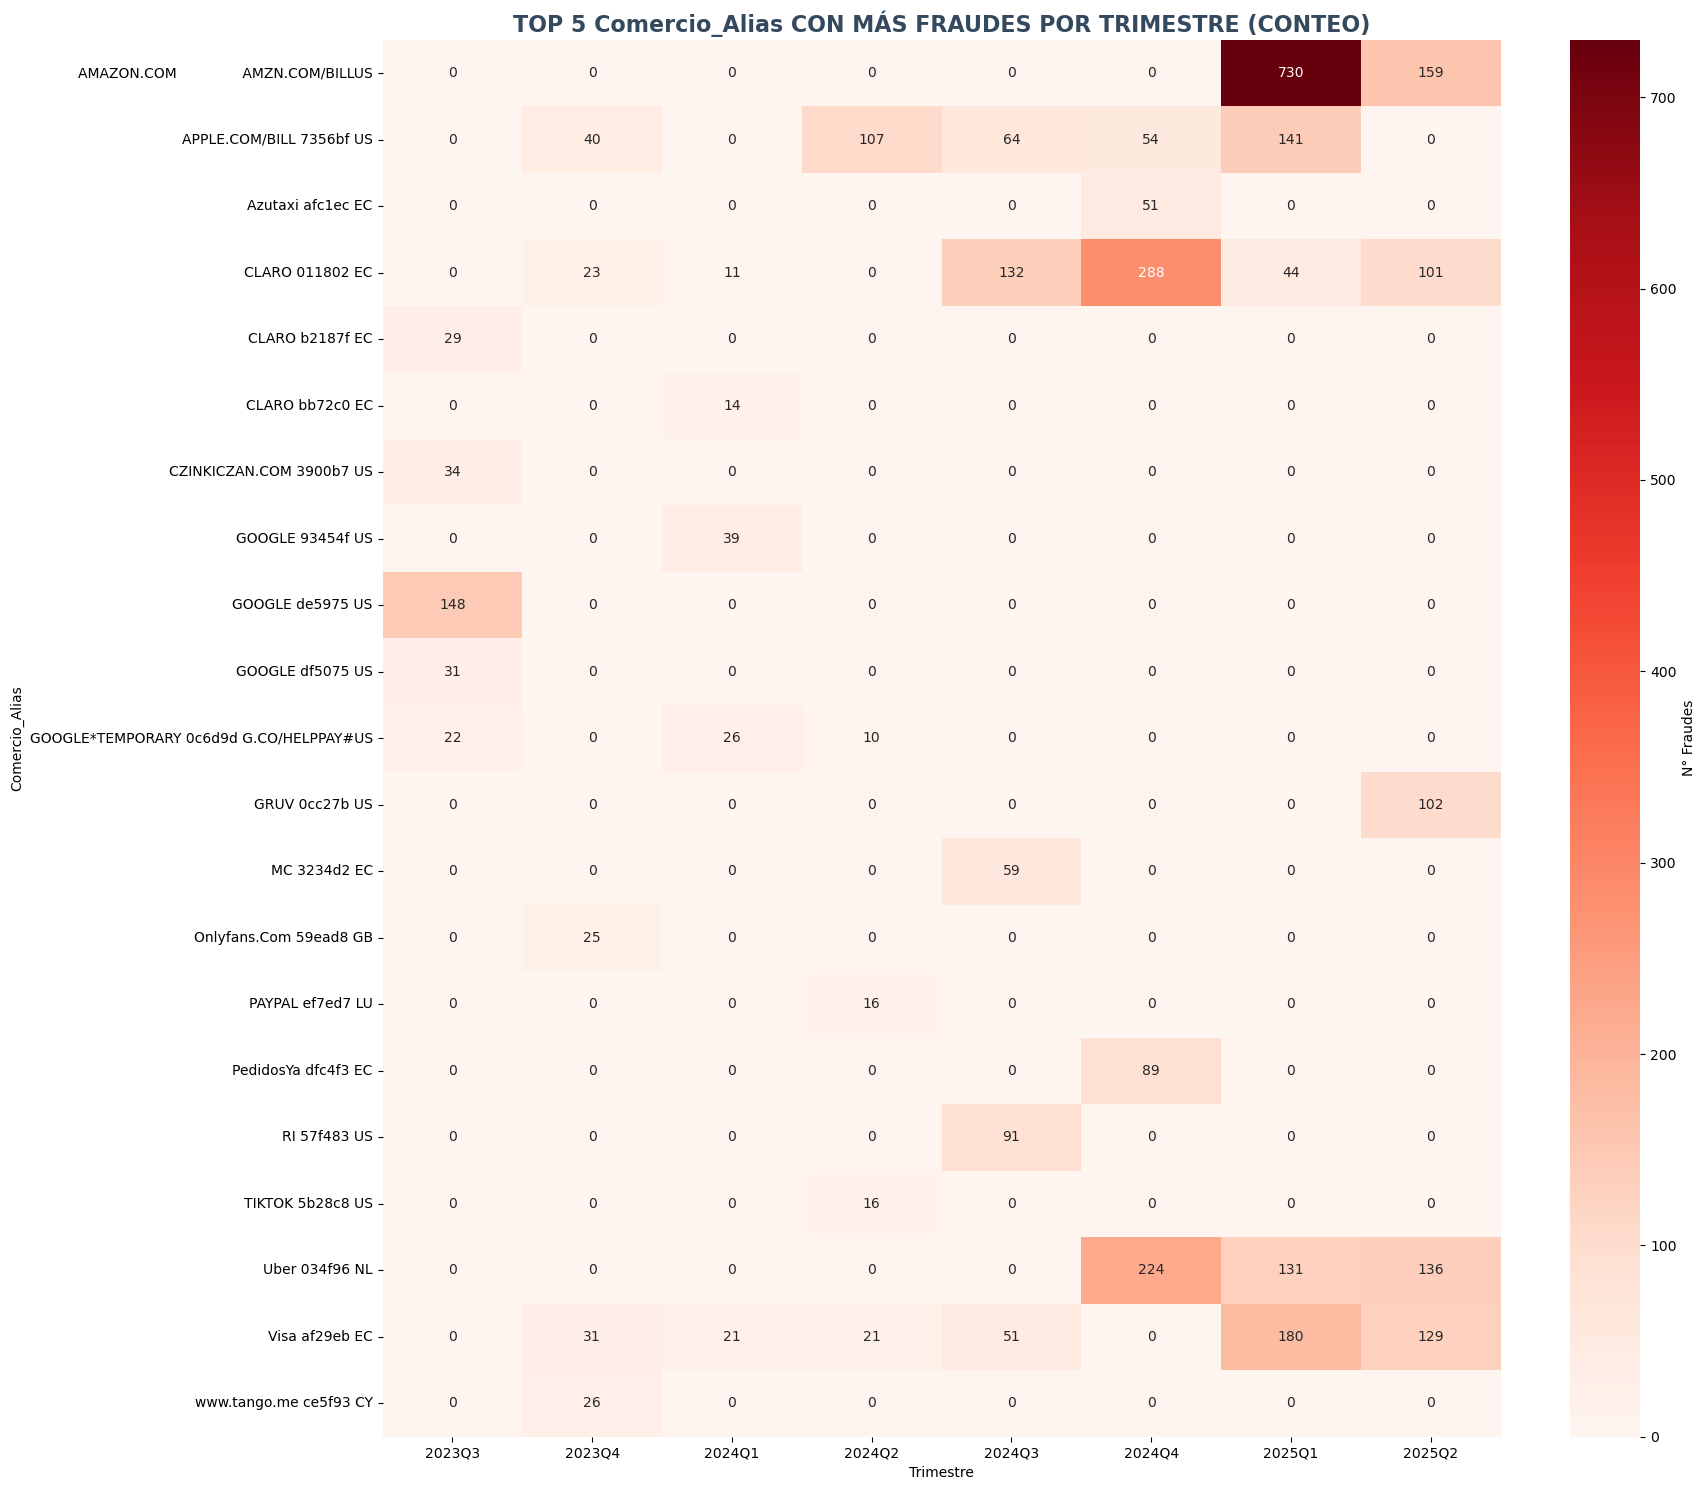

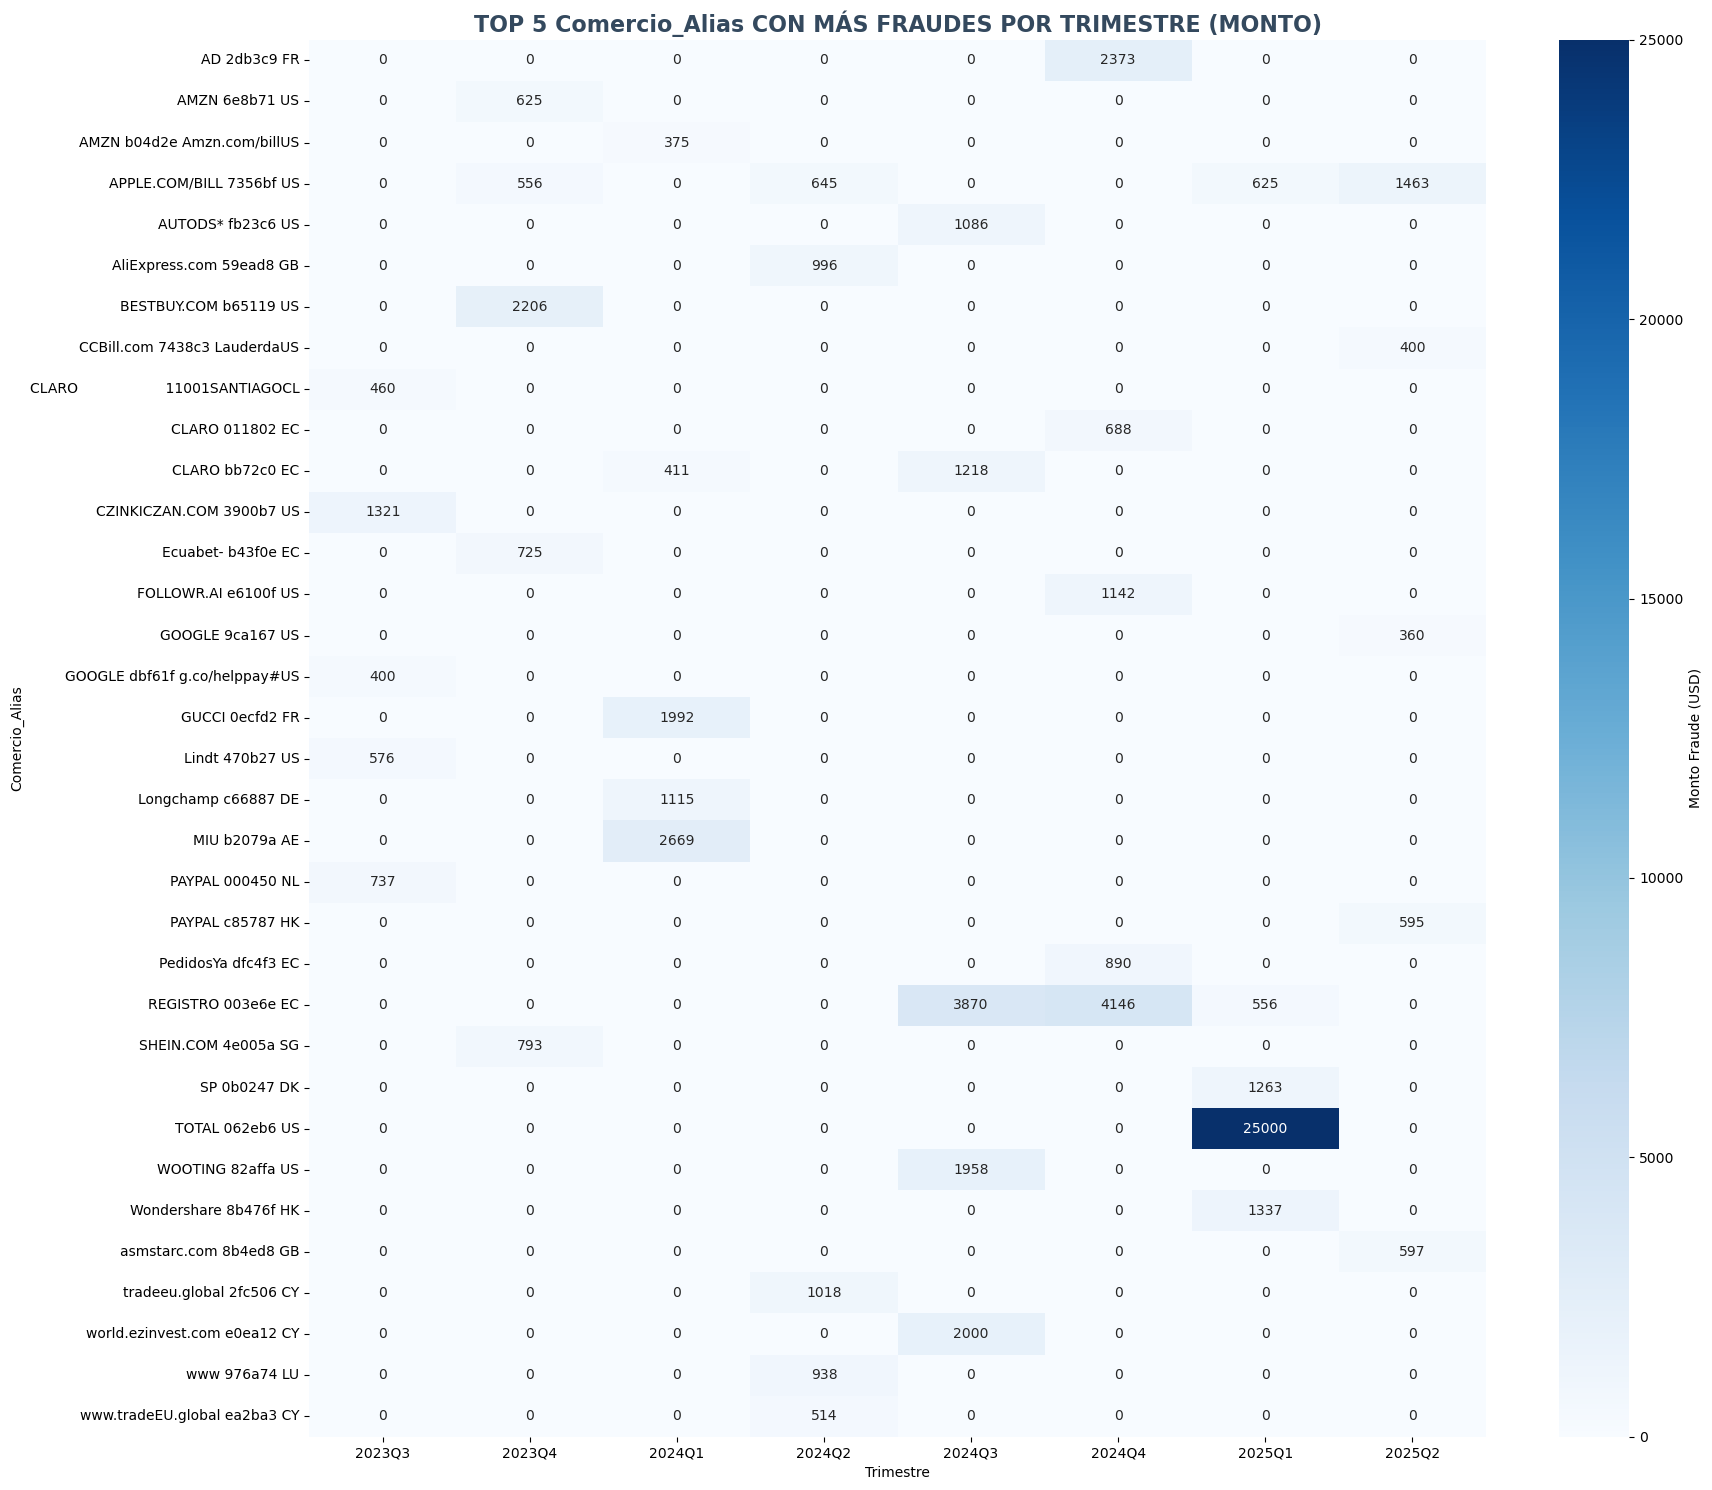

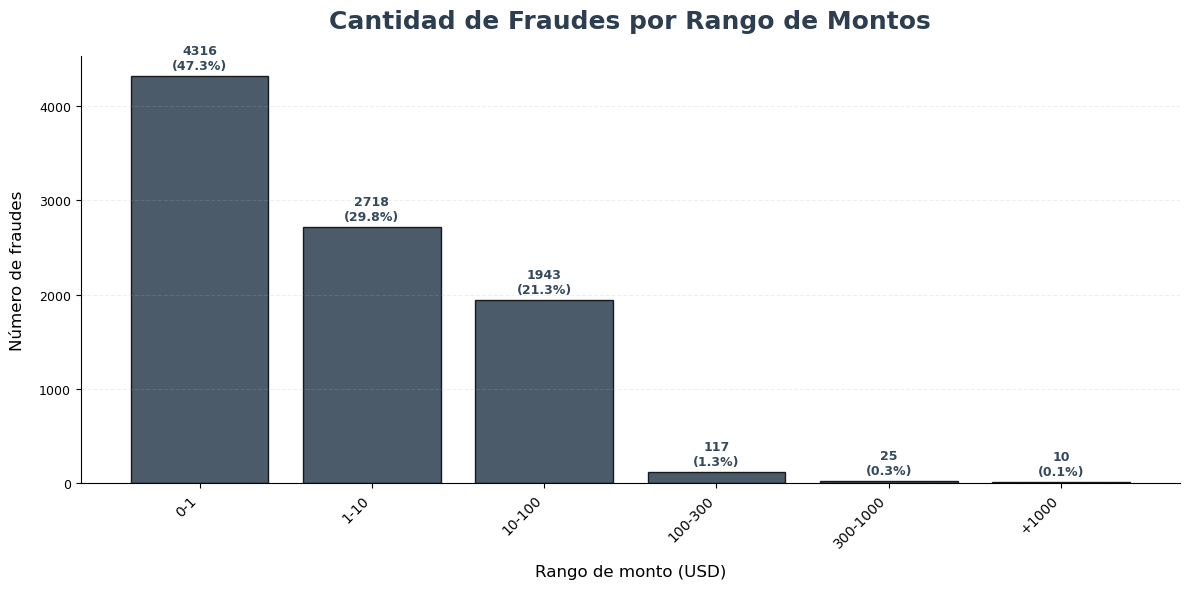

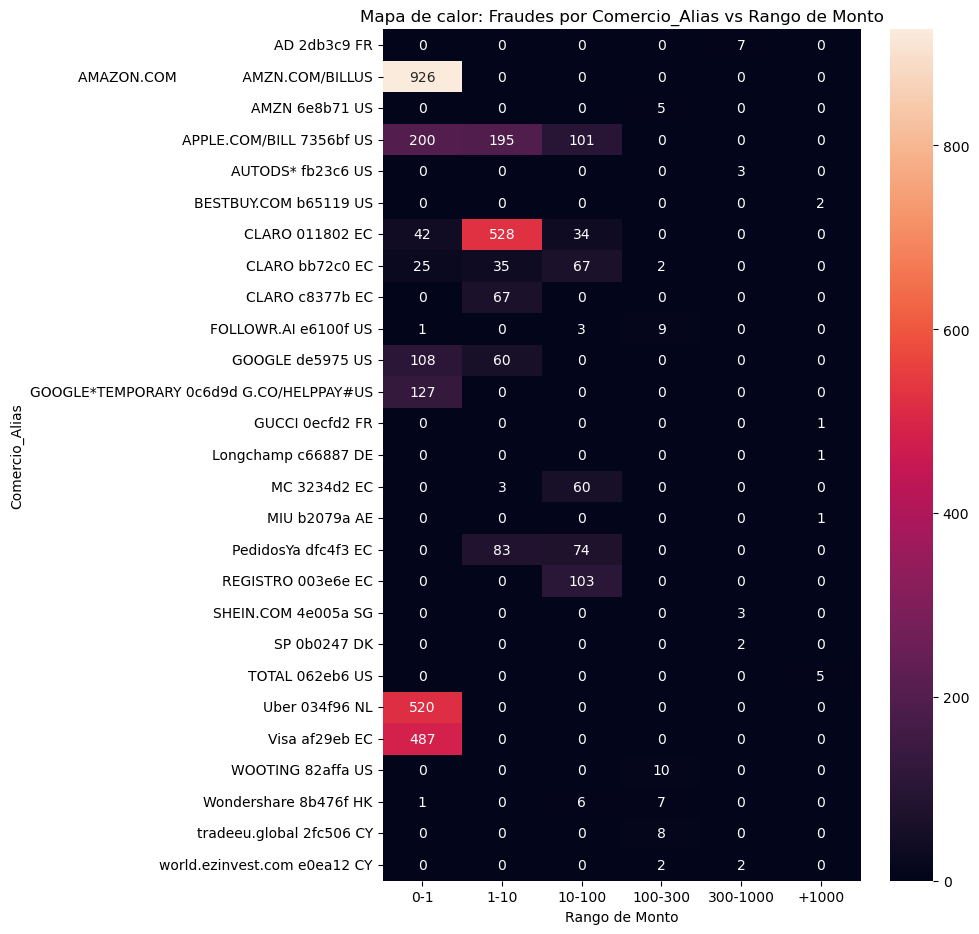

In [ ]:


# CAMPO objetivo para el análisis: cambia solo esta variable
CAMPO_PRIMARIO = "Comercio_Alias"  

TOP_N = 5  # cantidad top por reporte

# ---- Conteo de transacciones fraudulentas ----
pivot_conteo = pd.pivot_table(
    df_patrones_fraudes_f,
    values='Id_Trx',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='count',
    fill_value=0
)
pivot_conteo['TOTAL'] = pivot_conteo.sum(axis=1)
pivot_conteo_sorted = pivot_conteo.sort_values(by='TOTAL', ascending=False)

# ---- Monto total de fraude por CAMPO ----
pivot_monto = pd.pivot_table(
    df_patrones_fraudes_f,
    values='DE6_Monto_Dolar',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)
pivot_monto['TOTAL'] = pivot_monto.sum(axis=1)
pivot_monto_sorted = pivot_monto.sort_values(by='TOTAL', ascending=False).round(1)

# ---- Heatmaps ----
plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_conteo_sorted.head(20),  # Mostrar top 
    annot=True, fmt="d", cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_monto_sorted.head(20),  # Mostrar top 
    annot=True, fmt=".0f", cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupa fraudes por trimestre y campo ----
fraudes_trim = df_patrones_fraudes_f.groupby(['trimestre', CAMPO_PRIMARIO]).agg(
    fraudes=('Id_Trx', 'count'),
    monto_fraude=('DE6_Monto_Dolar', 'sum')
).reset_index()

# ---- Top CAMPO por trimestre (conteo fraudes) ----
top_conteo = (
    fraudes_trim.sort_values(['trimestre', 'fraudes'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_conteo = top_conteo.pivot_table(
    values='fraudes',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

# ---- Top CAMPO por trimestre (monto defraudado) ----
top_monto = (
    fraudes_trim.sort_values(['trimestre', 'monto_fraude'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_monto = top_monto.pivot_table(
    values='monto_fraude',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_conteo,
    annot=True,
    fmt="d",
    cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_monto,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupar por rangos de montos usando 'rango_monto' ----
fraude_por_rango = (
    df_patrones_fraudes_f.groupby("rango_monto", observed=True)
    .agg(
        Total_Transacciones=("Fraude", "size"),
        Total_Fraudes=("Fraude", "sum"),
        Monto_Fraude_Total=("DE6_Monto_Dolar", "sum")
    ).reset_index()
)

plt.figure(figsize=(12,6))
ax = plt.bar(
    fraude_por_rango["rango_monto"], 
    fraude_por_rango["Total_Fraudes"], 
    color="#2c3e50", 
    edgecolor="black", 
    alpha=0.85
)
plt.title("Cantidad de Fraudes por Rango de Montos", fontsize=18, fontweight="bold", color="#2c3e50", pad=20)
plt.xlabel("Rango de monto (USD)", fontsize=12, labelpad=10)
plt.ylabel("Número de fraudes", fontsize=12, labelpad=10)
plt.grid(axis="y", alpha=0.2, linestyle="--")
total_fraudes = fraude_por_rango["Total_Fraudes"].sum()
porc_fraudes = (fraude_por_rango["Total_Fraudes"] / total_fraudes * 100).round(2)
for i, (valor, pct) in enumerate(zip(fraude_por_rango["Total_Fraudes"], porc_fraudes)):
    plt.text(
        i, 
        valor + (max(fraude_por_rango["Total_Fraudes"]) * 0.01),
        f"{valor}\n({pct:.1f}%)", 
        ha="center", va="bottom", fontsize=9, fontweight="bold", color="#34495e"
    )
ax = plt.gca()
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

# ---- Top por rango por CAMPO objetivo ----
top_por_rango = (
    df_patrones_fraudes_f
    .groupby(["rango_monto", CAMPO_PRIMARIO], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
)
top_por_rango[CAMPO_PRIMARIO] = top_por_rango[CAMPO_PRIMARIO].astype(str)
top_por_rango = (
    top_por_rango
    .sort_values(["rango_monto", "Total_Fraudes"], ascending=[True, False])
    .groupby("rango_monto", observed=True)
    .head(TOP_N)
    .reset_index(drop=True)
)
top_union = sorted(top_por_rango[CAMPO_PRIMARIO].unique())

heat_df = (
    df_patrones_fraudes_f
    .assign(hash_campo=df_patrones_fraudes_f[CAMPO_PRIMARIO].astype(str))
    .groupby([CAMPO_PRIMARIO, "rango_monto"], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
    .query(f"{CAMPO_PRIMARIO} in @top_union")
)
heat_pivot = (
    heat_df
    .pivot(index=CAMPO_PRIMARIO, columns="rango_monto", values="Total_Fraudes")
    .fillna(0)
    .astype(int)
    .reindex(index=top_union)
)

plt.figure(figsize=(10, max(6, len(top_union) * 0.35)))
ax = sns.heatmap(
    heat_pivot,
    annot=True, fmt="d",
)
ax.set_title(f"Mapa de calor: Fraudes por {CAMPO_PRIMARIO} vs Rango de Monto")
ax.set_xlabel("Rango de Monto")
ax.set_ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()


## Análisis de Fraude por Código pais para Tarjetas No Presente (CNP)

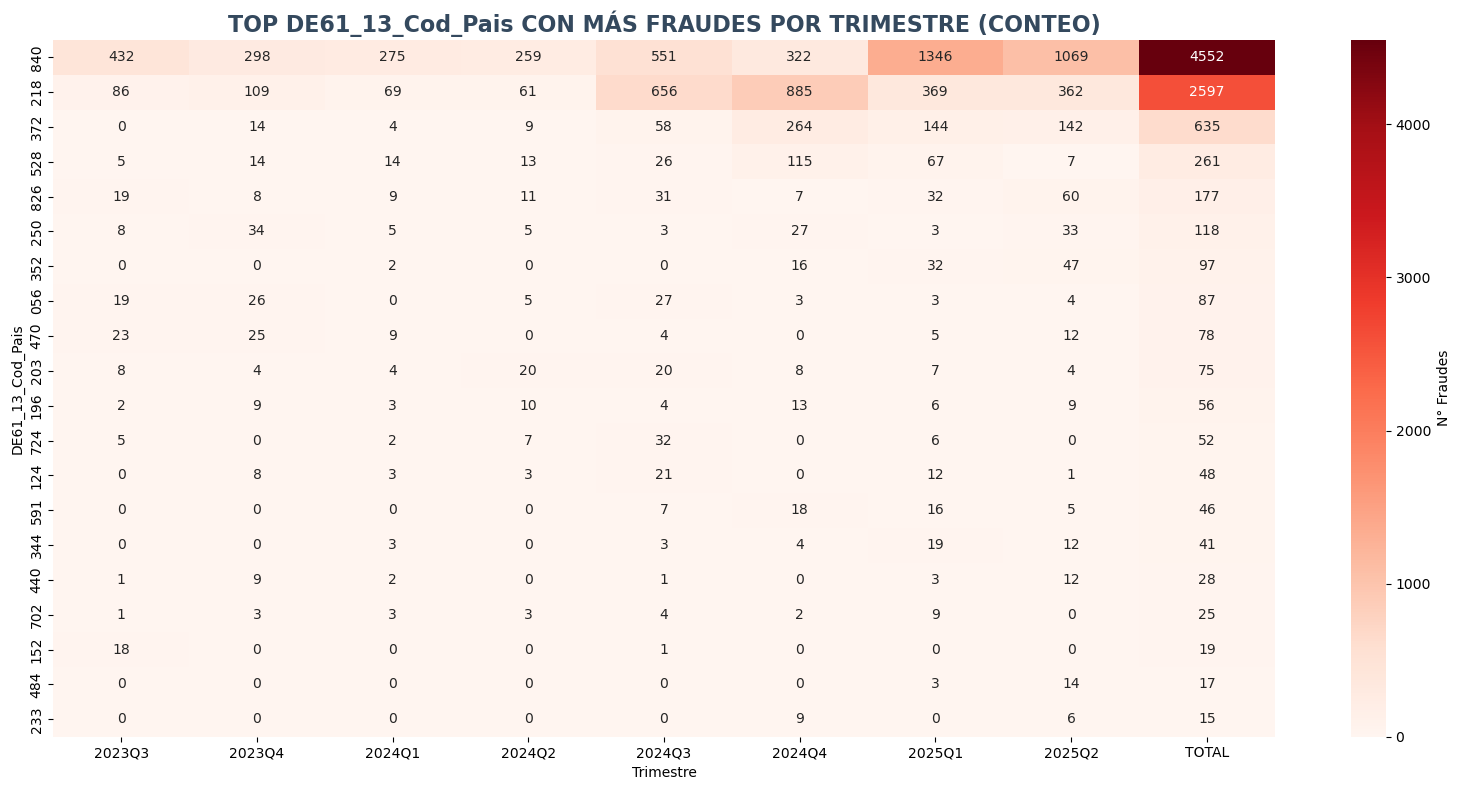

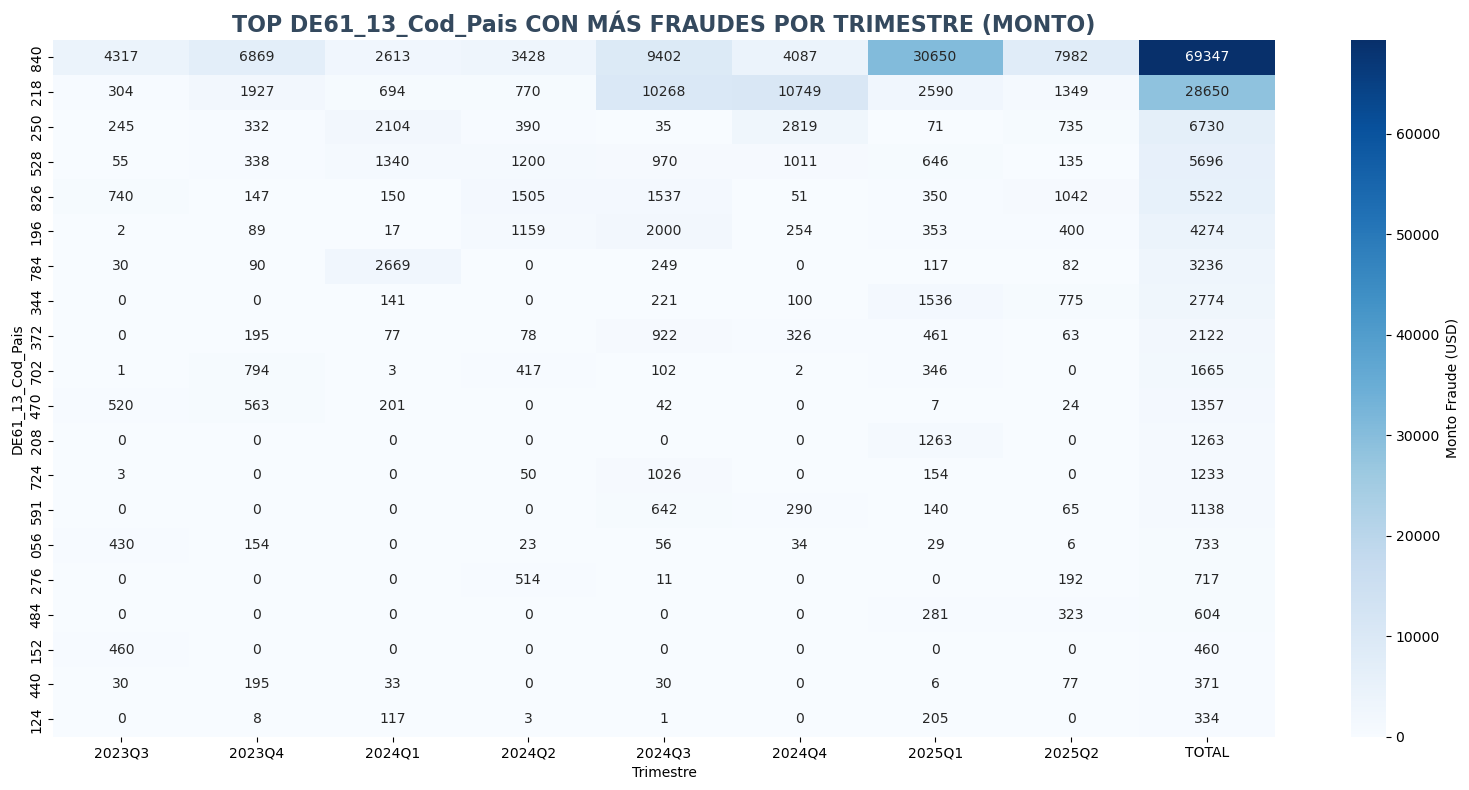

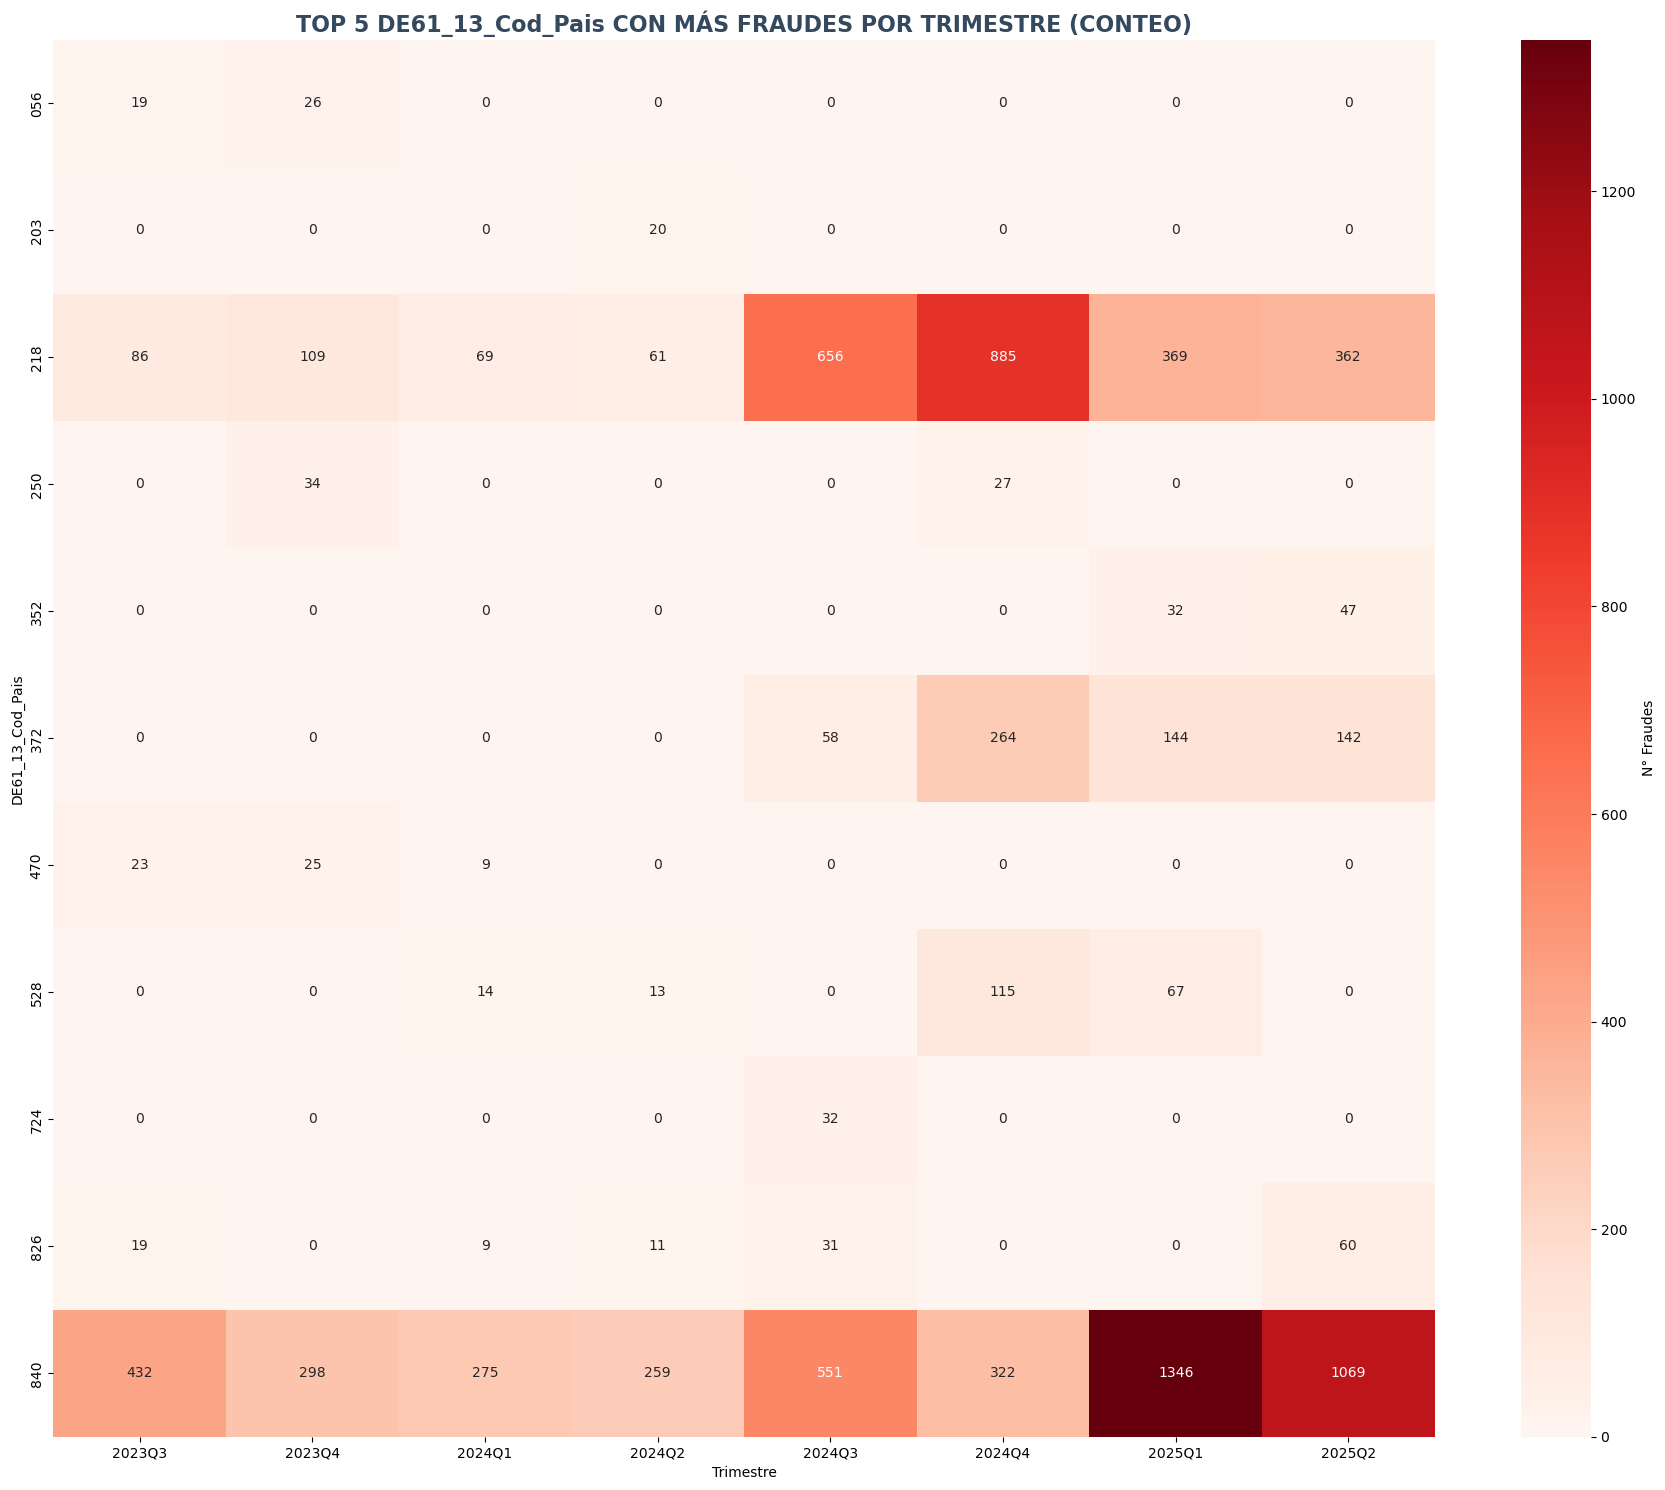

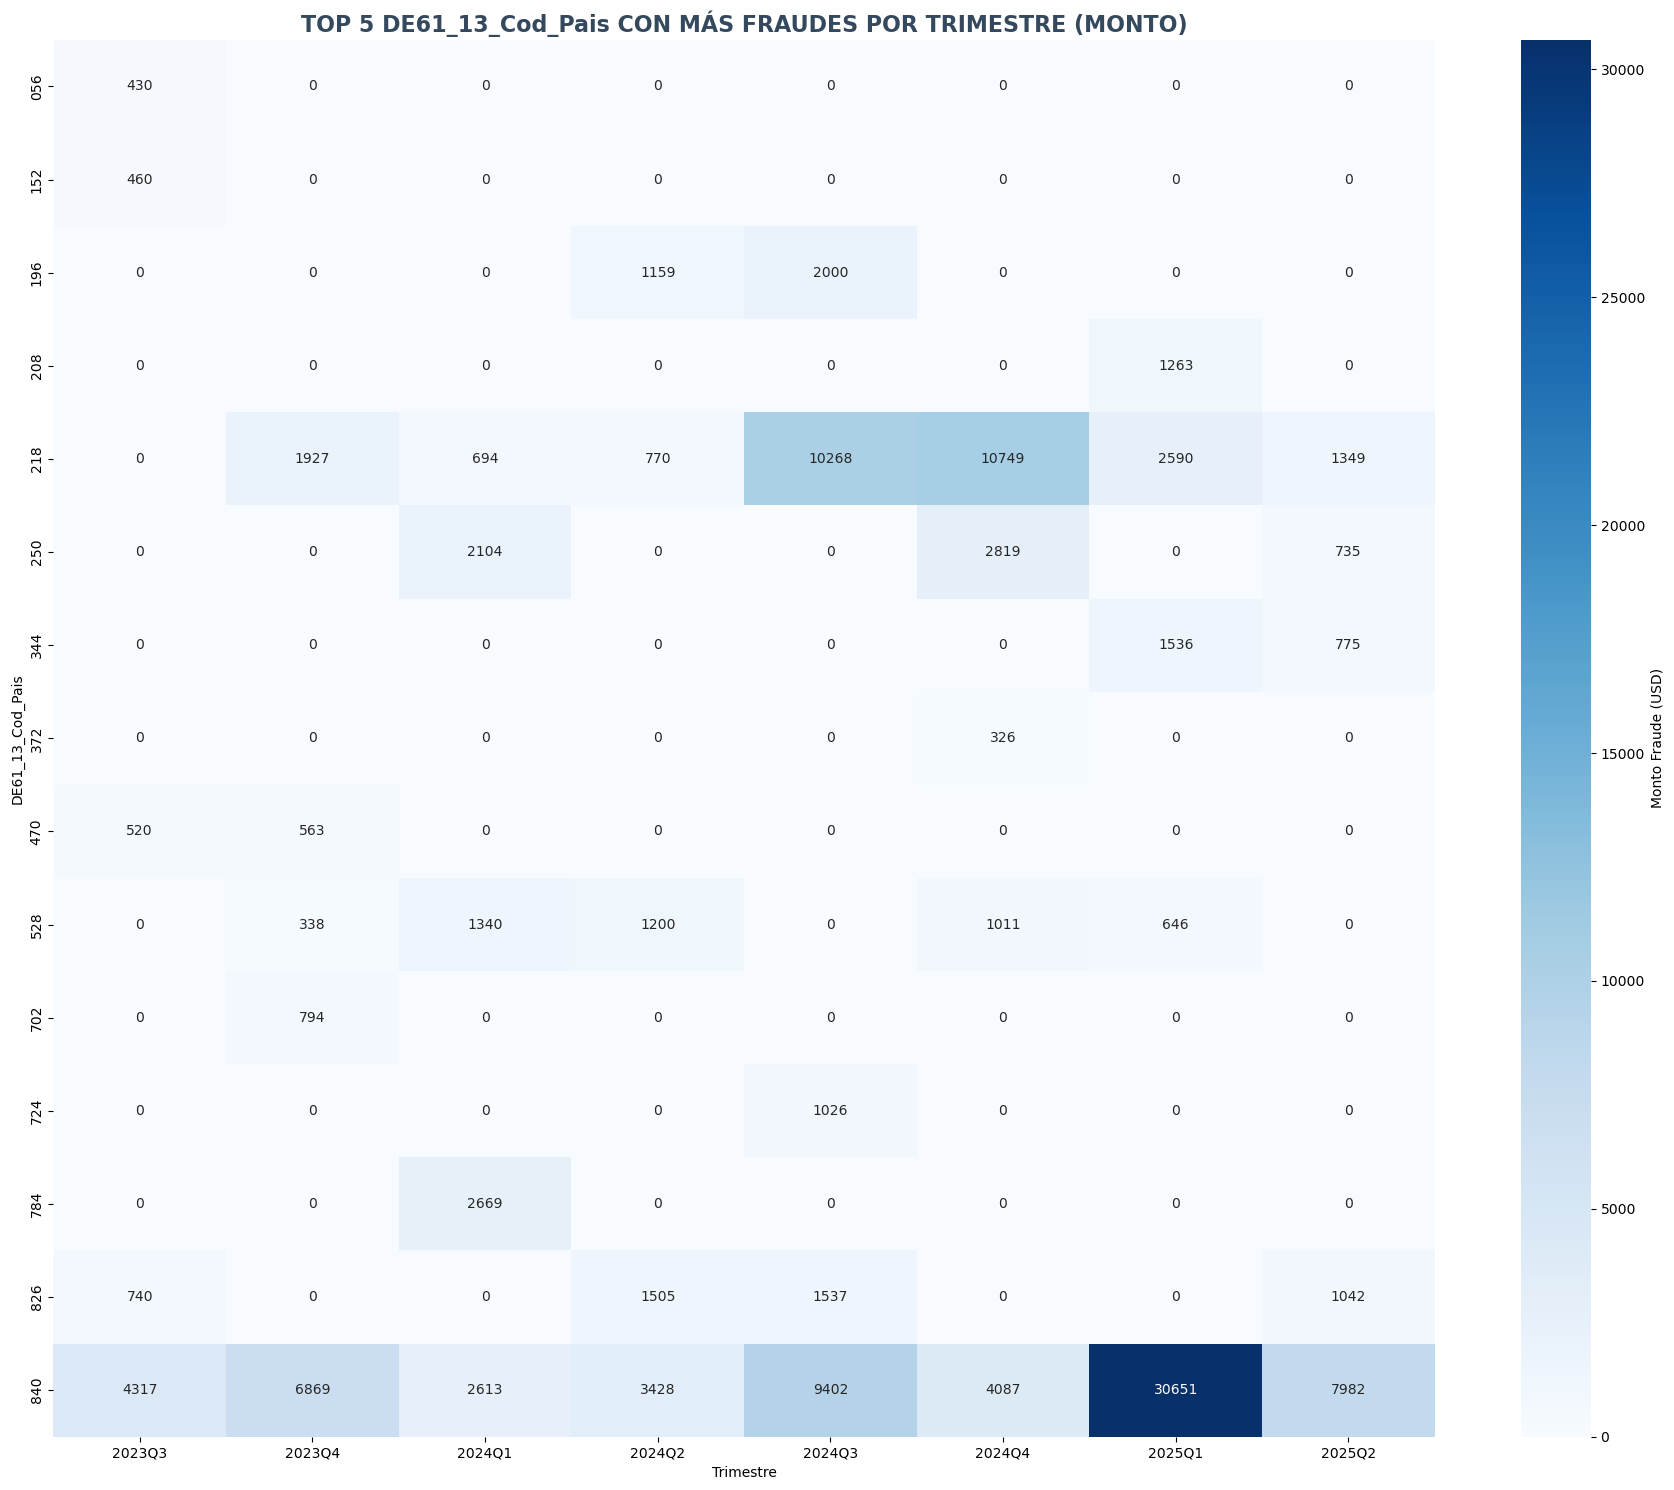

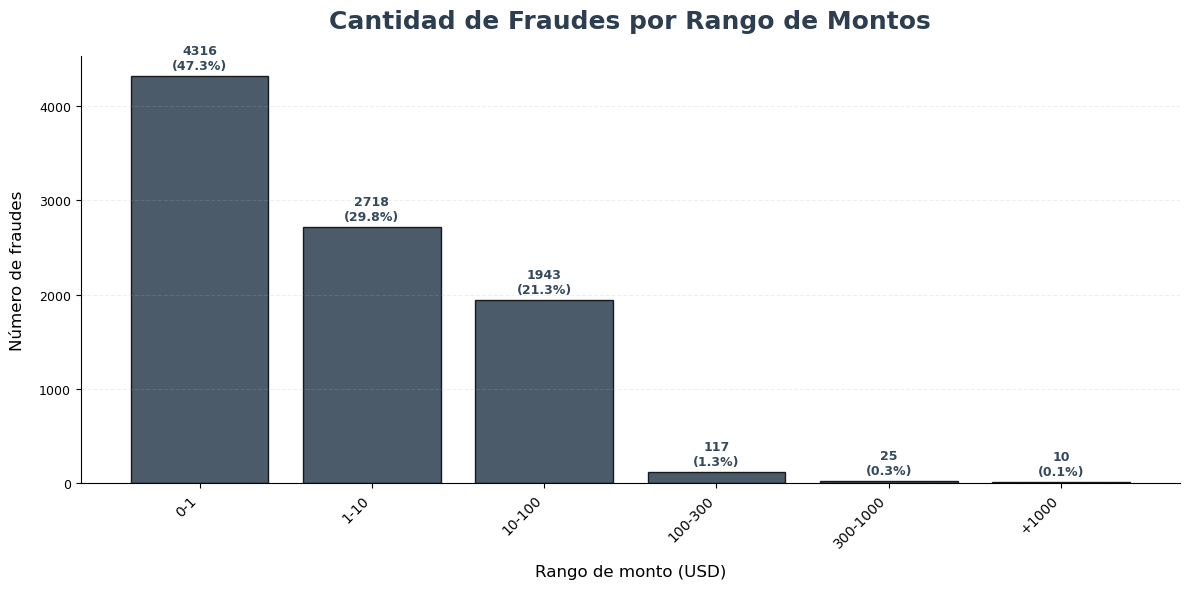

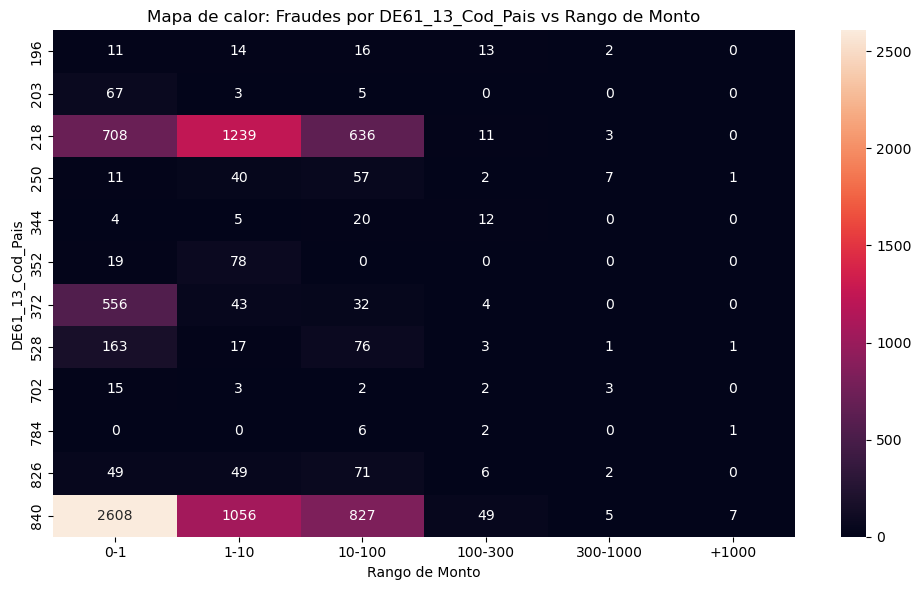

In [115]:

# CAMPO objetivo para el análisis: cambia solo esta variable
CAMPO_PRIMARIO = "DE61_13_Cod_Pais"  

TOP_N = 5  # cantidad top por reporte

# ---- Conteo de transacciones fraudulentas ----
pivot_conteo = pd.pivot_table(
    df_patrones_fraudes_f,
    values='Id_Trx',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='count',
    fill_value=0
)
pivot_conteo['TOTAL'] = pivot_conteo.sum(axis=1)
pivot_conteo_sorted = pivot_conteo.sort_values(by='TOTAL', ascending=False)

# ---- Monto total de fraude por CAMPO ----
pivot_monto = pd.pivot_table(
    df_patrones_fraudes_f,
    values='DE6_Monto_Dolar',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)
pivot_monto['TOTAL'] = pivot_monto.sum(axis=1)
pivot_monto_sorted = pivot_monto.sort_values(by='TOTAL', ascending=False).round(1)

# ---- Heatmaps ----
plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_conteo_sorted.head(20),  # Mostrar top 
    annot=True, fmt="d", cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_monto_sorted.head(20),  # Mostrar top 
    annot=True, fmt=".0f", cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupa fraudes por trimestre y campo ----
fraudes_trim = df_patrones_fraudes_f.groupby(['trimestre', CAMPO_PRIMARIO]).agg(
    fraudes=('Id_Trx', 'count'),
    monto_fraude=('DE6_Monto_Dolar', 'sum')
).reset_index()

# ---- Top CAMPO por trimestre (conteo fraudes) ----
top_conteo = (
    fraudes_trim.sort_values(['trimestre', 'fraudes'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_conteo = top_conteo.pivot_table(
    values='fraudes',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

# ---- Top CAMPO por trimestre (monto defraudado) ----
top_monto = (
    fraudes_trim.sort_values(['trimestre', 'monto_fraude'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_monto = top_monto.pivot_table(
    values='monto_fraude',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_conteo,
    annot=True,
    fmt="d",
    cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_monto,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupar por rangos de montos usando 'rango_monto' ----
fraude_por_rango = (
    df_patrones_fraudes_f.groupby("rango_monto", observed=True)
    .agg(
        Total_Transacciones=("Fraude", "size"),
        Total_Fraudes=("Fraude", "sum"),
        Monto_Fraude_Total=("DE6_Monto_Dolar", "sum")
    ).reset_index()
)

plt.figure(figsize=(12,6))
ax = plt.bar(
    fraude_por_rango["rango_monto"], 
    fraude_por_rango["Total_Fraudes"], 
    color="#2c3e50", 
    edgecolor="black", 
    alpha=0.85
)
plt.title("Cantidad de Fraudes por Rango de Montos", fontsize=18, fontweight="bold", color="#2c3e50", pad=20)
plt.xlabel("Rango de monto (USD)", fontsize=12, labelpad=10)
plt.ylabel("Número de fraudes", fontsize=12, labelpad=10)
plt.grid(axis="y", alpha=0.2, linestyle="--")
total_fraudes = fraude_por_rango["Total_Fraudes"].sum()
porc_fraudes = (fraude_por_rango["Total_Fraudes"] / total_fraudes * 100).round(2)
for i, (valor, pct) in enumerate(zip(fraude_por_rango["Total_Fraudes"], porc_fraudes)):
    plt.text(
        i, 
        valor + (max(fraude_por_rango["Total_Fraudes"]) * 0.01),
        f"{valor}\n({pct:.1f}%)", 
        ha="center", va="bottom", fontsize=9, fontweight="bold", color="#34495e"
    )
ax = plt.gca()
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

# ---- Top por rango por CAMPO objetivo ----
top_por_rango = (
    df_patrones_fraudes_f
    .groupby(["rango_monto", CAMPO_PRIMARIO], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
)
top_por_rango[CAMPO_PRIMARIO] = top_por_rango[CAMPO_PRIMARIO].astype(str)
top_por_rango = (
    top_por_rango
    .sort_values(["rango_monto", "Total_Fraudes"], ascending=[True, False])
    .groupby("rango_monto", observed=True)
    .head(TOP_N)
    .reset_index(drop=True)
)
top_union = sorted(top_por_rango[CAMPO_PRIMARIO].unique())

heat_df = (
    df_patrones_fraudes_f
    .assign(hash_campo=df_patrones_fraudes_f[CAMPO_PRIMARIO].astype(str))
    .groupby([CAMPO_PRIMARIO, "rango_monto"], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
    .query(f"{CAMPO_PRIMARIO} in @top_union")
)
heat_pivot = (
    heat_df
    .pivot(index=CAMPO_PRIMARIO, columns="rango_monto", values="Total_Fraudes")
    .fillna(0)
    .astype(int)
    .reindex(index=top_union)
)

plt.figure(figsize=(10, max(6, len(top_union) * 0.35)))
ax = sns.heatmap(
    heat_pivot,
    annot=True, fmt="d",
)
ax.set_title(f"Mapa de calor: Fraudes por {CAMPO_PRIMARIO} vs Rango de Monto")
ax.set_xlabel("Rango de Monto")
ax.set_ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()


## Análisis de Fraude por MCC para Tarjetas No Presente (CNP)

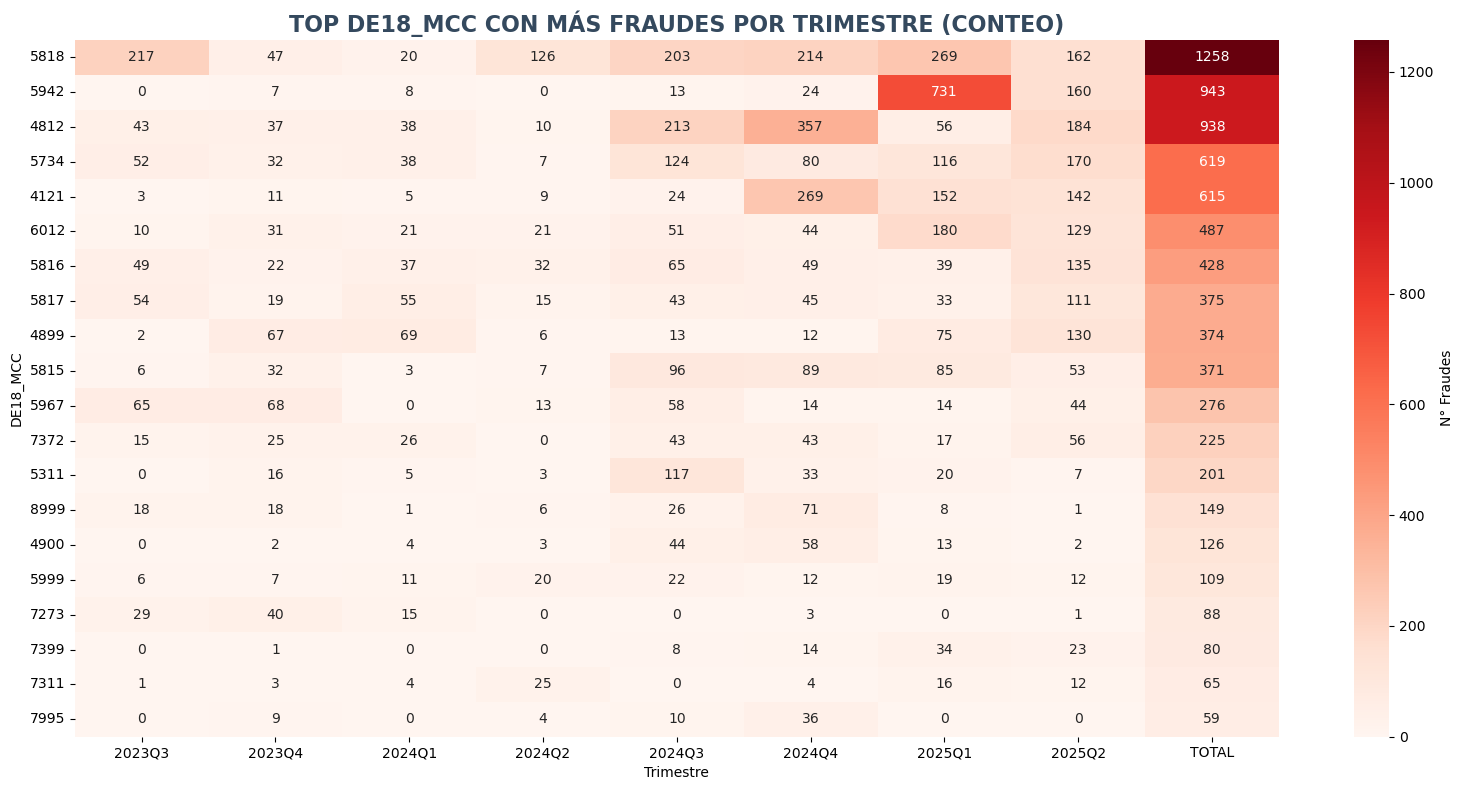

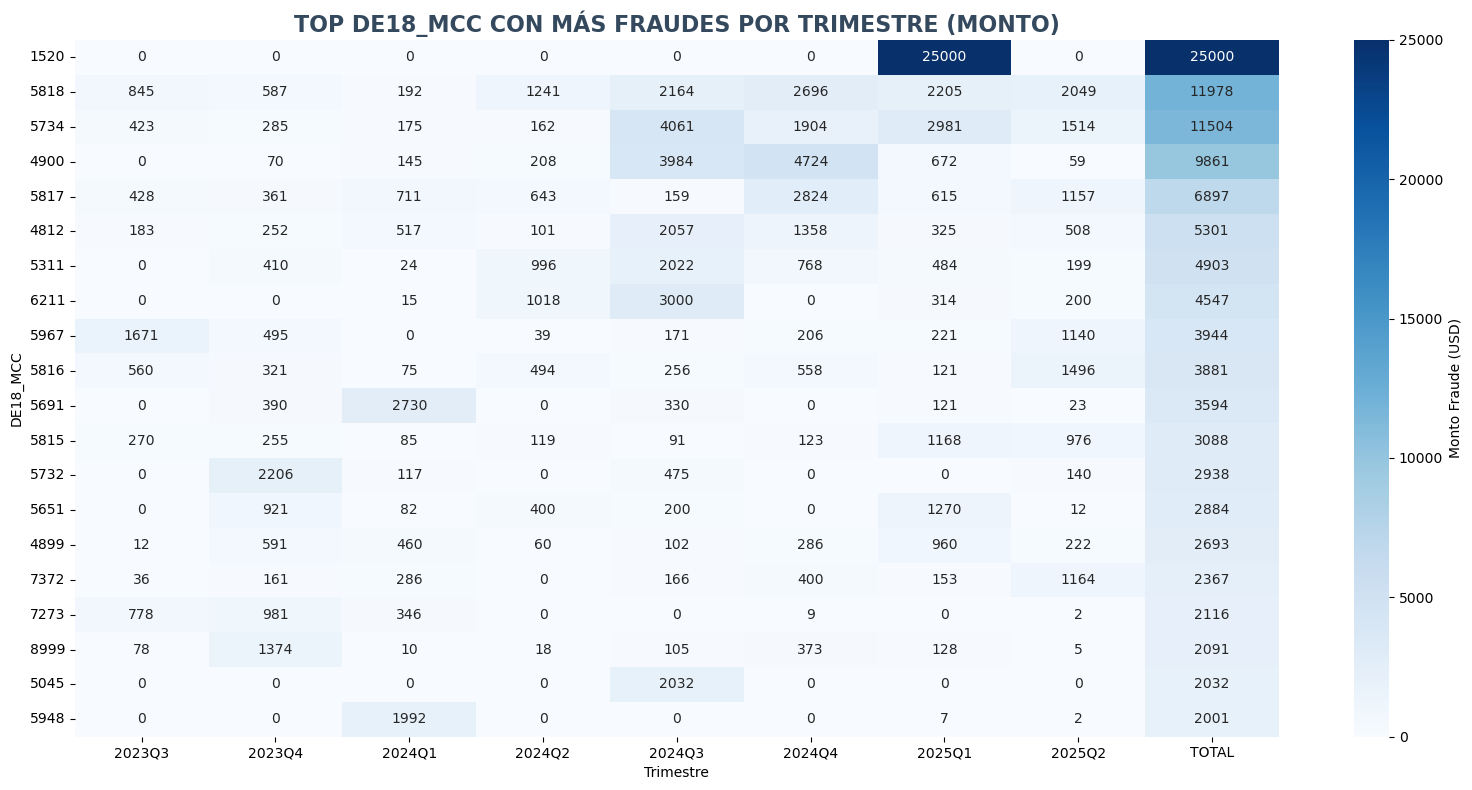

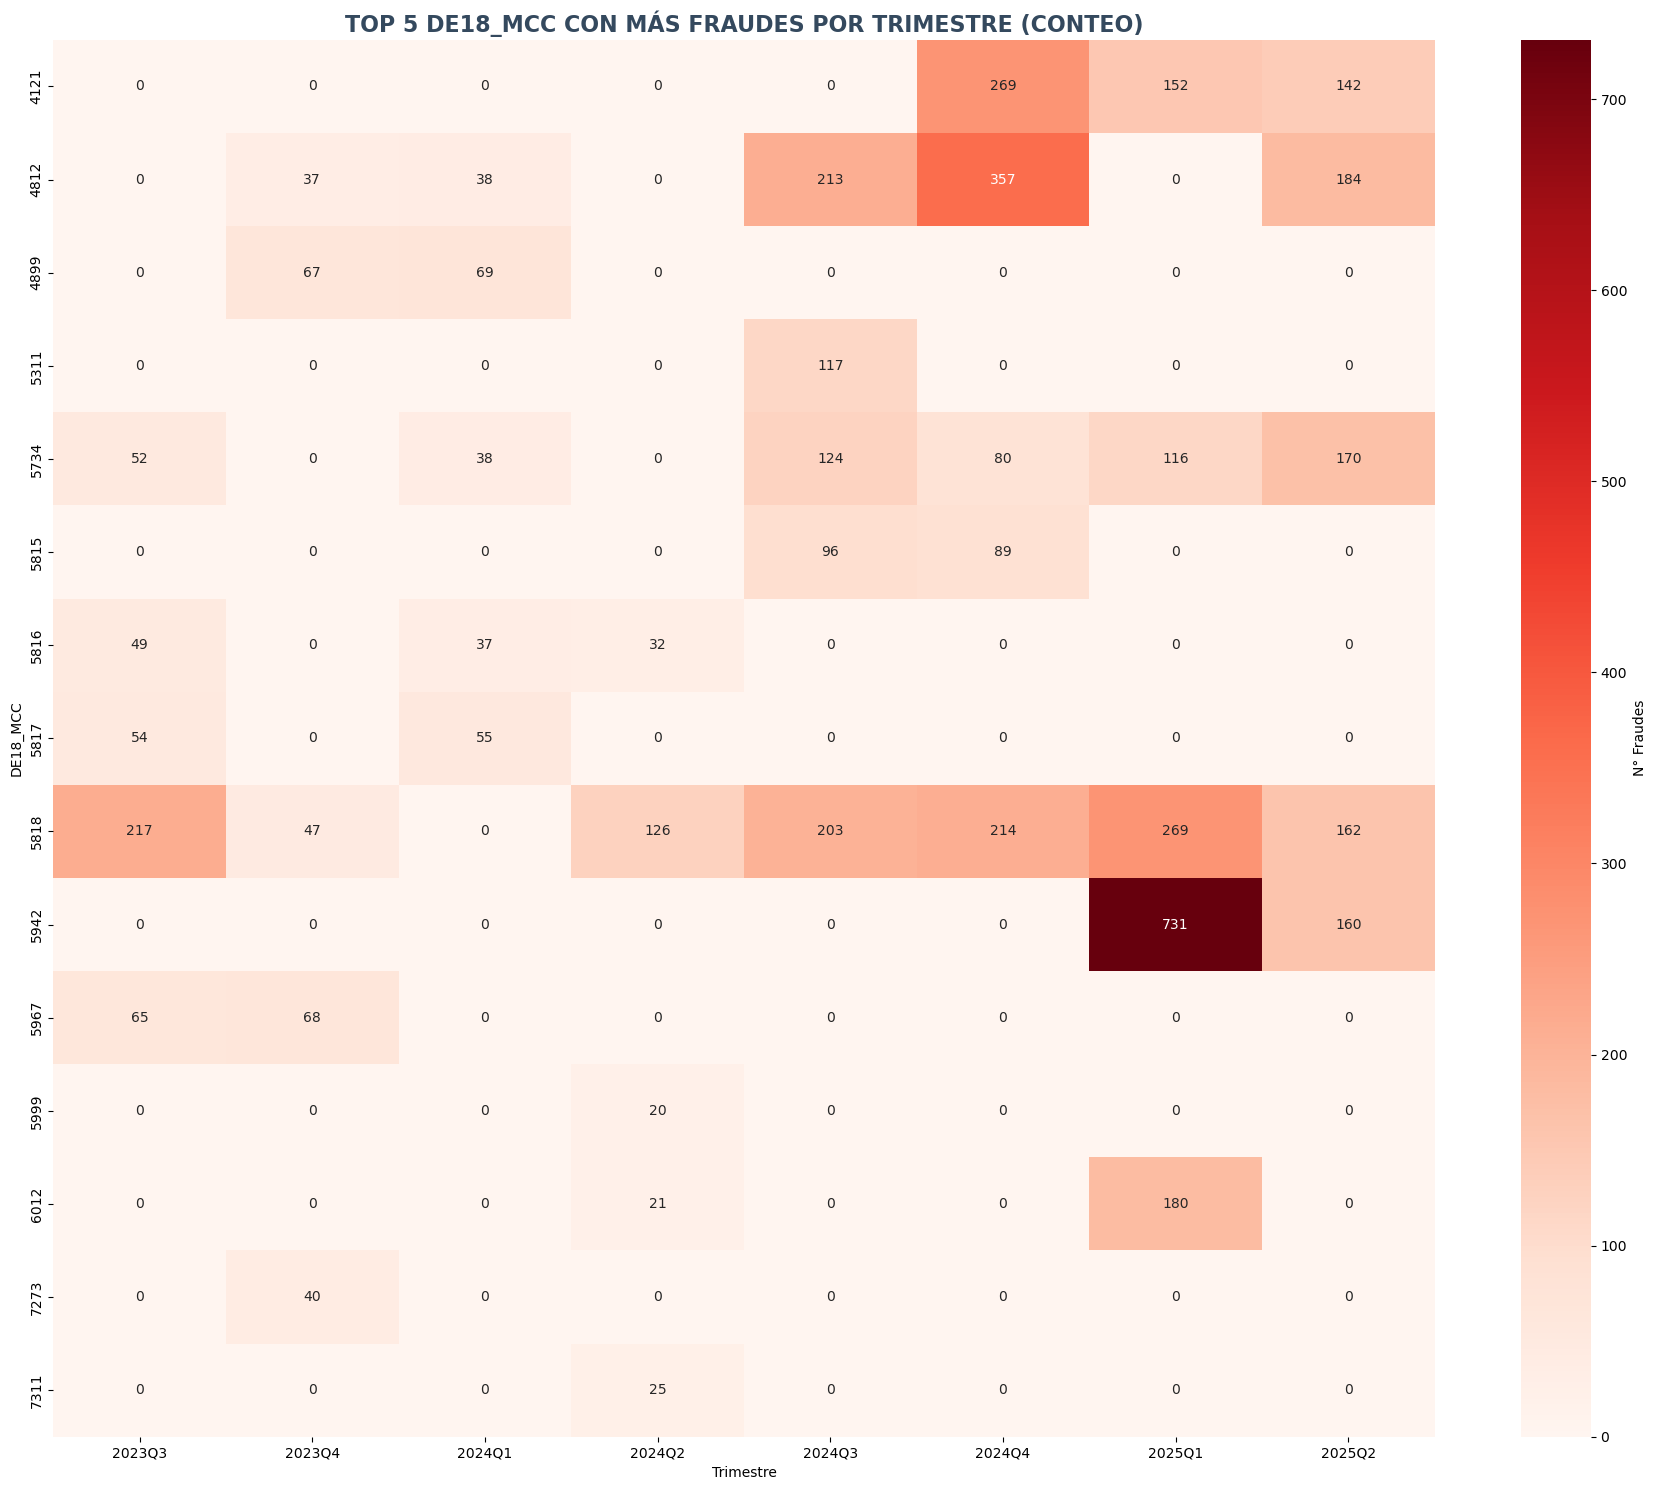

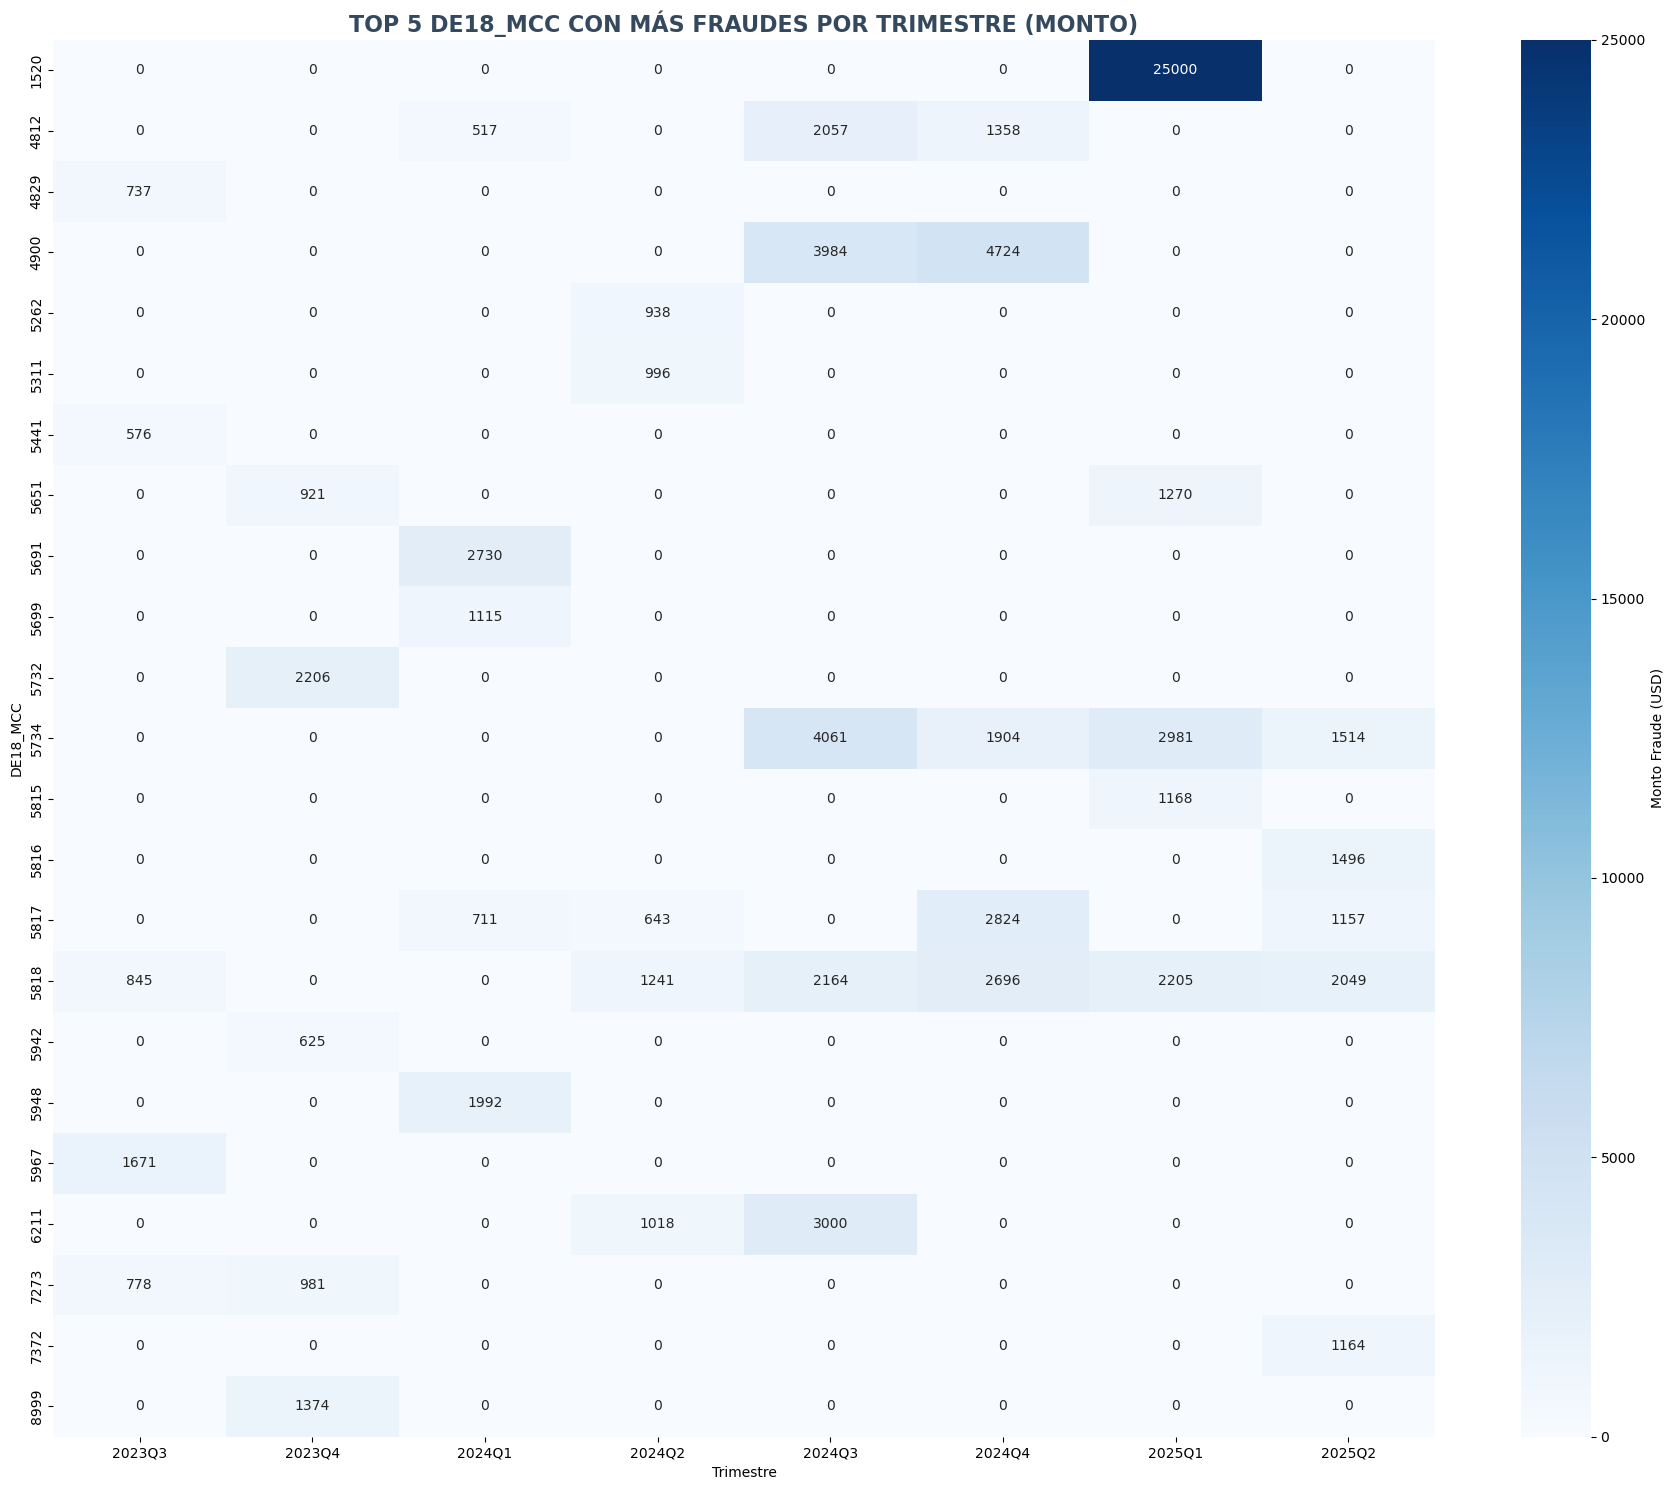

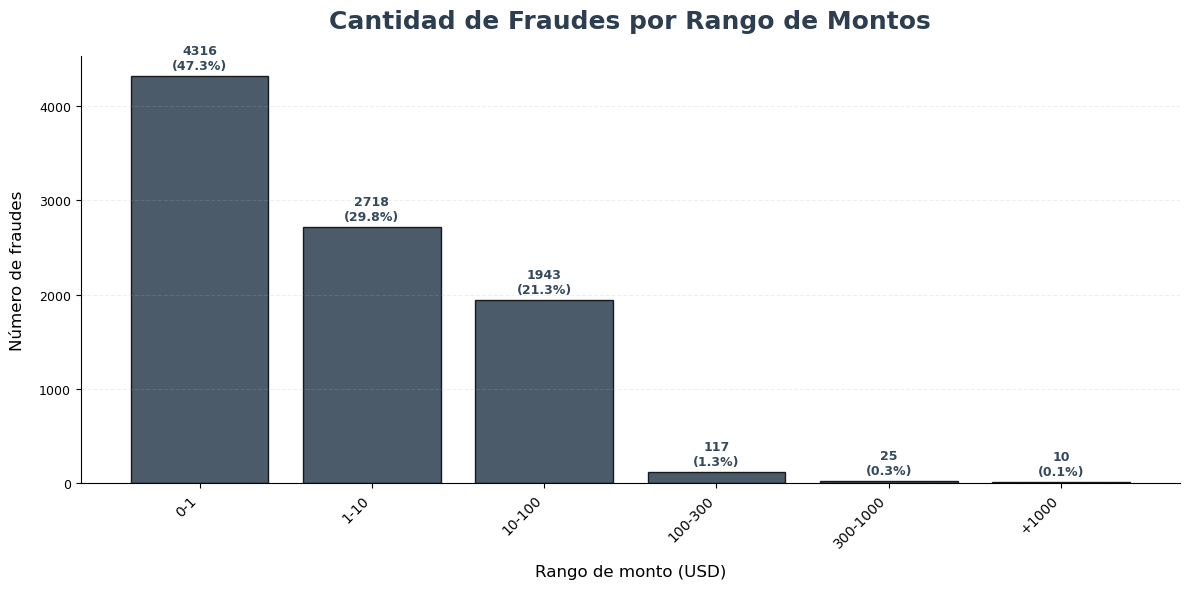

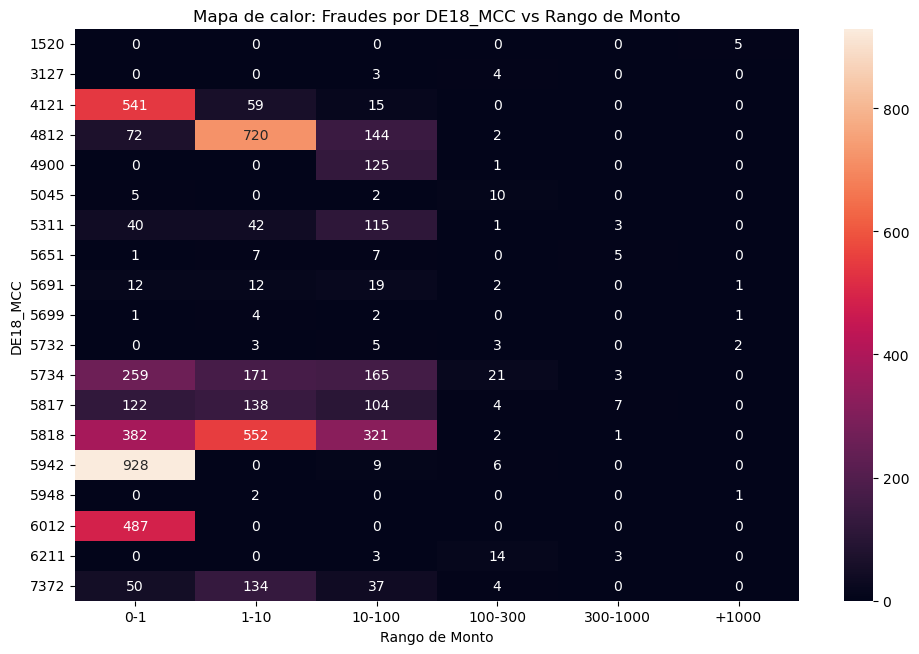

In [116]:
# CAMPO objetivo para el análisis: cambia solo esta variable
CAMPO_PRIMARIO = "DE18_MCC"  

TOP_N = 5  # cantidad top por reporte

# ---- Conteo de transacciones fraudulentas ----
pivot_conteo = pd.pivot_table(
    df_patrones_fraudes_f,
    values='Id_Trx',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='count',
    fill_value=0
)
pivot_conteo['TOTAL'] = pivot_conteo.sum(axis=1)
pivot_conteo_sorted = pivot_conteo.sort_values(by='TOTAL', ascending=False)

# ---- Monto total de fraude por CAMPO ----
pivot_monto = pd.pivot_table(
    df_patrones_fraudes_f,
    values='DE6_Monto_Dolar',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)
pivot_monto['TOTAL'] = pivot_monto.sum(axis=1)
pivot_monto_sorted = pivot_monto.sort_values(by='TOTAL', ascending=False).round(1)

# ---- Heatmaps ----
plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_conteo_sorted.head(20),  # Mostrar top 
    annot=True, fmt="d", cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_monto_sorted.head(20),  # Mostrar top 
    annot=True, fmt=".0f", cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupa fraudes por trimestre y campo ----
fraudes_trim = df_patrones_fraudes_f.groupby(['trimestre', CAMPO_PRIMARIO]).agg(
    fraudes=('Id_Trx', 'count'),
    monto_fraude=('DE6_Monto_Dolar', 'sum')
).reset_index()

# ---- Top CAMPO por trimestre (conteo fraudes) ----
top_conteo = (
    fraudes_trim.sort_values(['trimestre', 'fraudes'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_conteo = top_conteo.pivot_table(
    values='fraudes',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

# ---- Top CAMPO por trimestre (monto defraudado) ----
top_monto = (
    fraudes_trim.sort_values(['trimestre', 'monto_fraude'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_monto = top_monto.pivot_table(
    values='monto_fraude',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_conteo,
    annot=True,
    fmt="d",
    cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_monto,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupar por rangos de montos usando 'rango_monto' ----
fraude_por_rango = (
    df_patrones_fraudes_f.groupby("rango_monto", observed=True)
    .agg(
        Total_Transacciones=("Fraude", "size"),
        Total_Fraudes=("Fraude", "sum"),
        Monto_Fraude_Total=("DE6_Monto_Dolar", "sum")
    ).reset_index()
)

plt.figure(figsize=(12,6))
ax = plt.bar(
    fraude_por_rango["rango_monto"], 
    fraude_por_rango["Total_Fraudes"], 
    color="#2c3e50", 
    edgecolor="black", 
    alpha=0.85
)
plt.title("Cantidad de Fraudes por Rango de Montos", fontsize=18, fontweight="bold", color="#2c3e50", pad=20)
plt.xlabel("Rango de monto (USD)", fontsize=12, labelpad=10)
plt.ylabel("Número de fraudes", fontsize=12, labelpad=10)
plt.grid(axis="y", alpha=0.2, linestyle="--")
total_fraudes = fraude_por_rango["Total_Fraudes"].sum()
porc_fraudes = (fraude_por_rango["Total_Fraudes"] / total_fraudes * 100).round(2)
for i, (valor, pct) in enumerate(zip(fraude_por_rango["Total_Fraudes"], porc_fraudes)):
    plt.text(
        i, 
        valor + (max(fraude_por_rango["Total_Fraudes"]) * 0.01),
        f"{valor}\n({pct:.1f}%)", 
        ha="center", va="bottom", fontsize=9, fontweight="bold", color="#34495e"
    )
ax = plt.gca()
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

# ---- Top por rango por CAMPO objetivo ----
top_por_rango = (
    df_patrones_fraudes_f
    .groupby(["rango_monto", CAMPO_PRIMARIO], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
)
top_por_rango[CAMPO_PRIMARIO] = top_por_rango[CAMPO_PRIMARIO].astype(str)
top_por_rango = (
    top_por_rango
    .sort_values(["rango_monto", "Total_Fraudes"], ascending=[True, False])
    .groupby("rango_monto", observed=True)
    .head(TOP_N)
    .reset_index(drop=True)
)
top_union = sorted(top_por_rango[CAMPO_PRIMARIO].unique())

heat_df = (
    df_patrones_fraudes_f
    .assign(hash_campo=df_patrones_fraudes_f[CAMPO_PRIMARIO].astype(str))
    .groupby([CAMPO_PRIMARIO, "rango_monto"], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
    .query(f"{CAMPO_PRIMARIO} in @top_union")
)
heat_pivot = (
    heat_df
    .pivot(index=CAMPO_PRIMARIO, columns="rango_monto", values="Total_Fraudes")
    .fillna(0)
    .astype(int)
    .reindex(index=top_union)
)

plt.figure(figsize=(10, max(6, len(top_union) * 0.35)))
ax = sns.heatmap(
    heat_pivot,
    annot=True, fmt="d",
)
ax.set_title(f"Mapa de calor: Fraudes por {CAMPO_PRIMARIO} vs Rango de Monto")
ax.set_xlabel("Rango de Monto")
ax.set_ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()


## Análisis de Fraude por Adquiriente para Tarjetas No Presente (CNP)


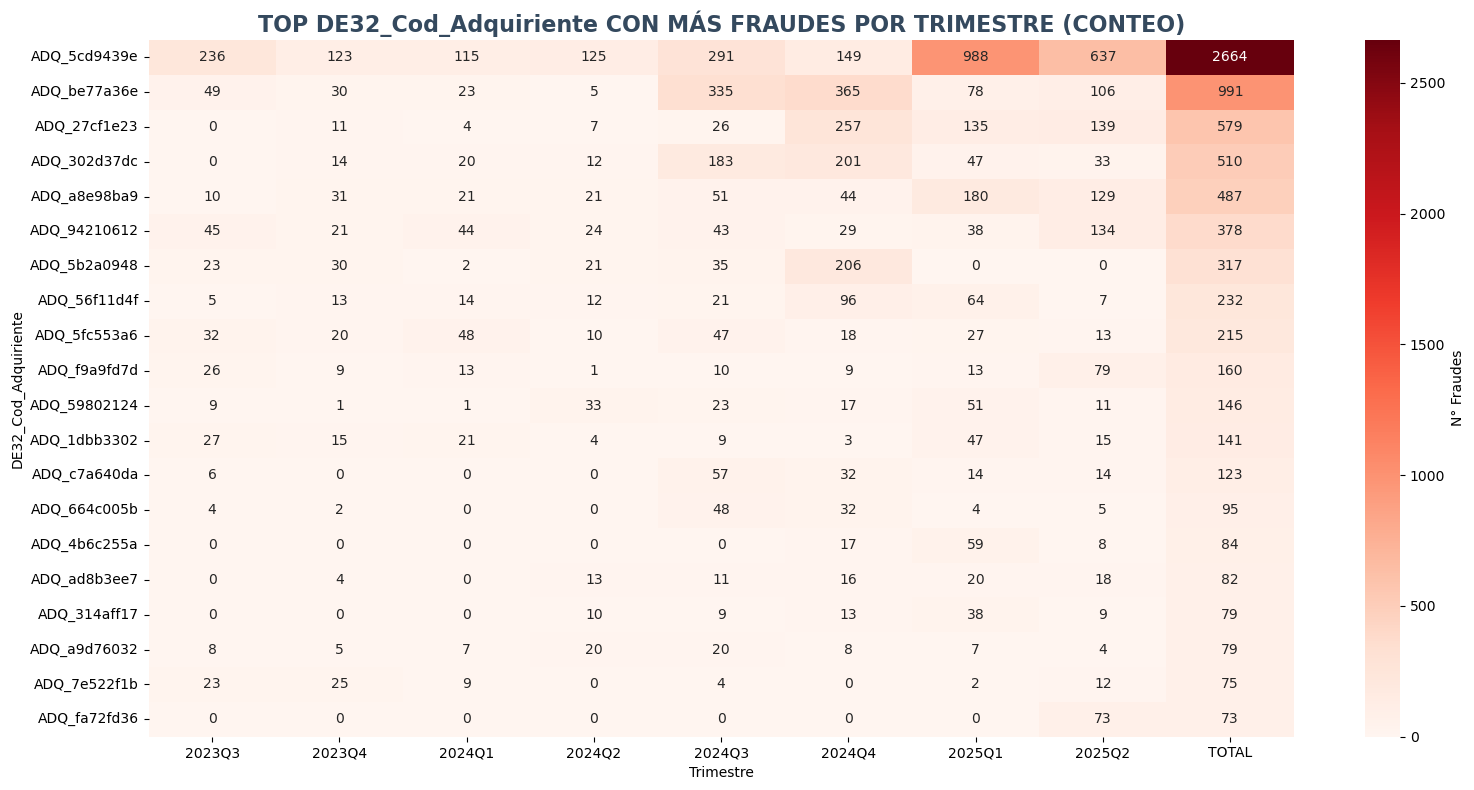

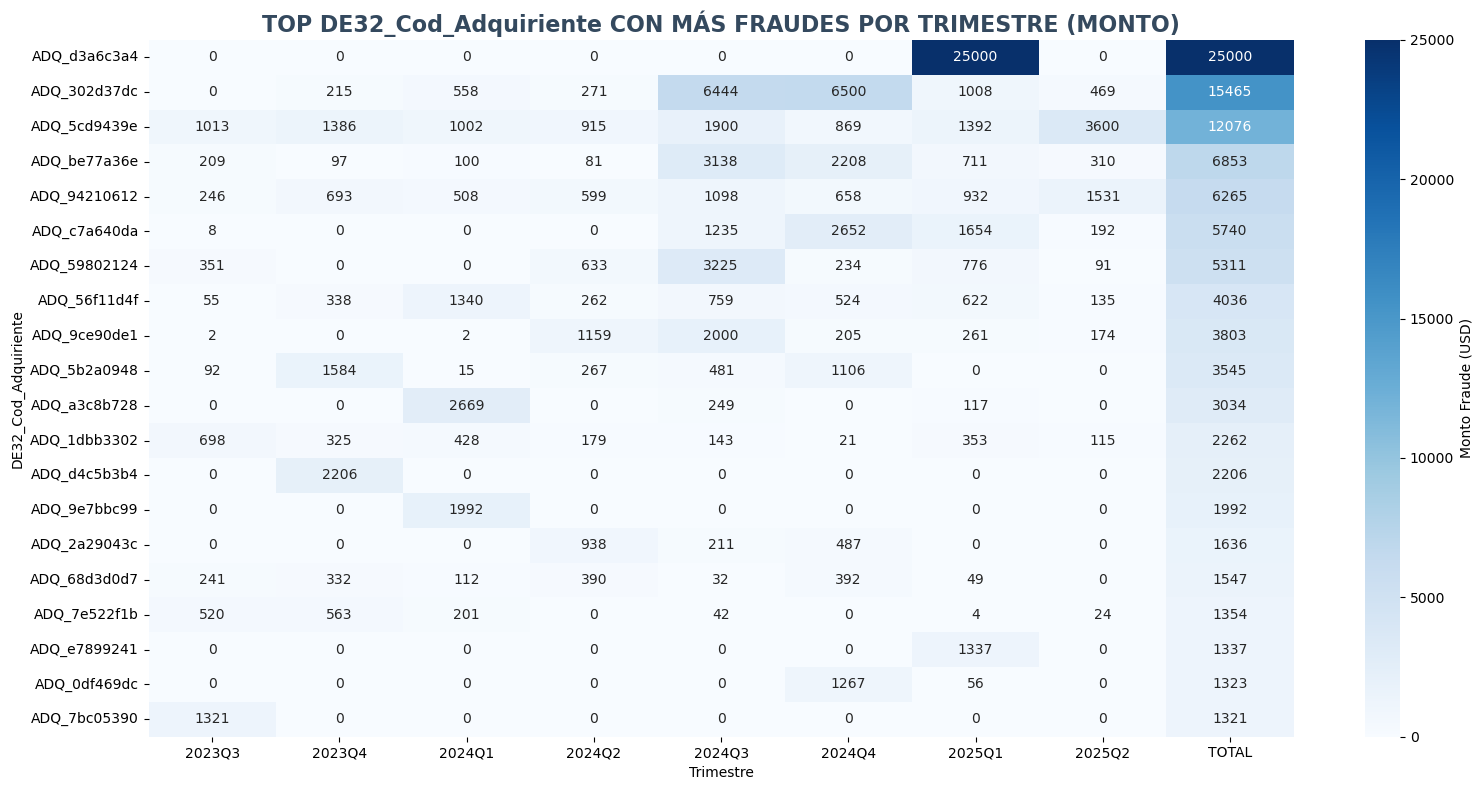

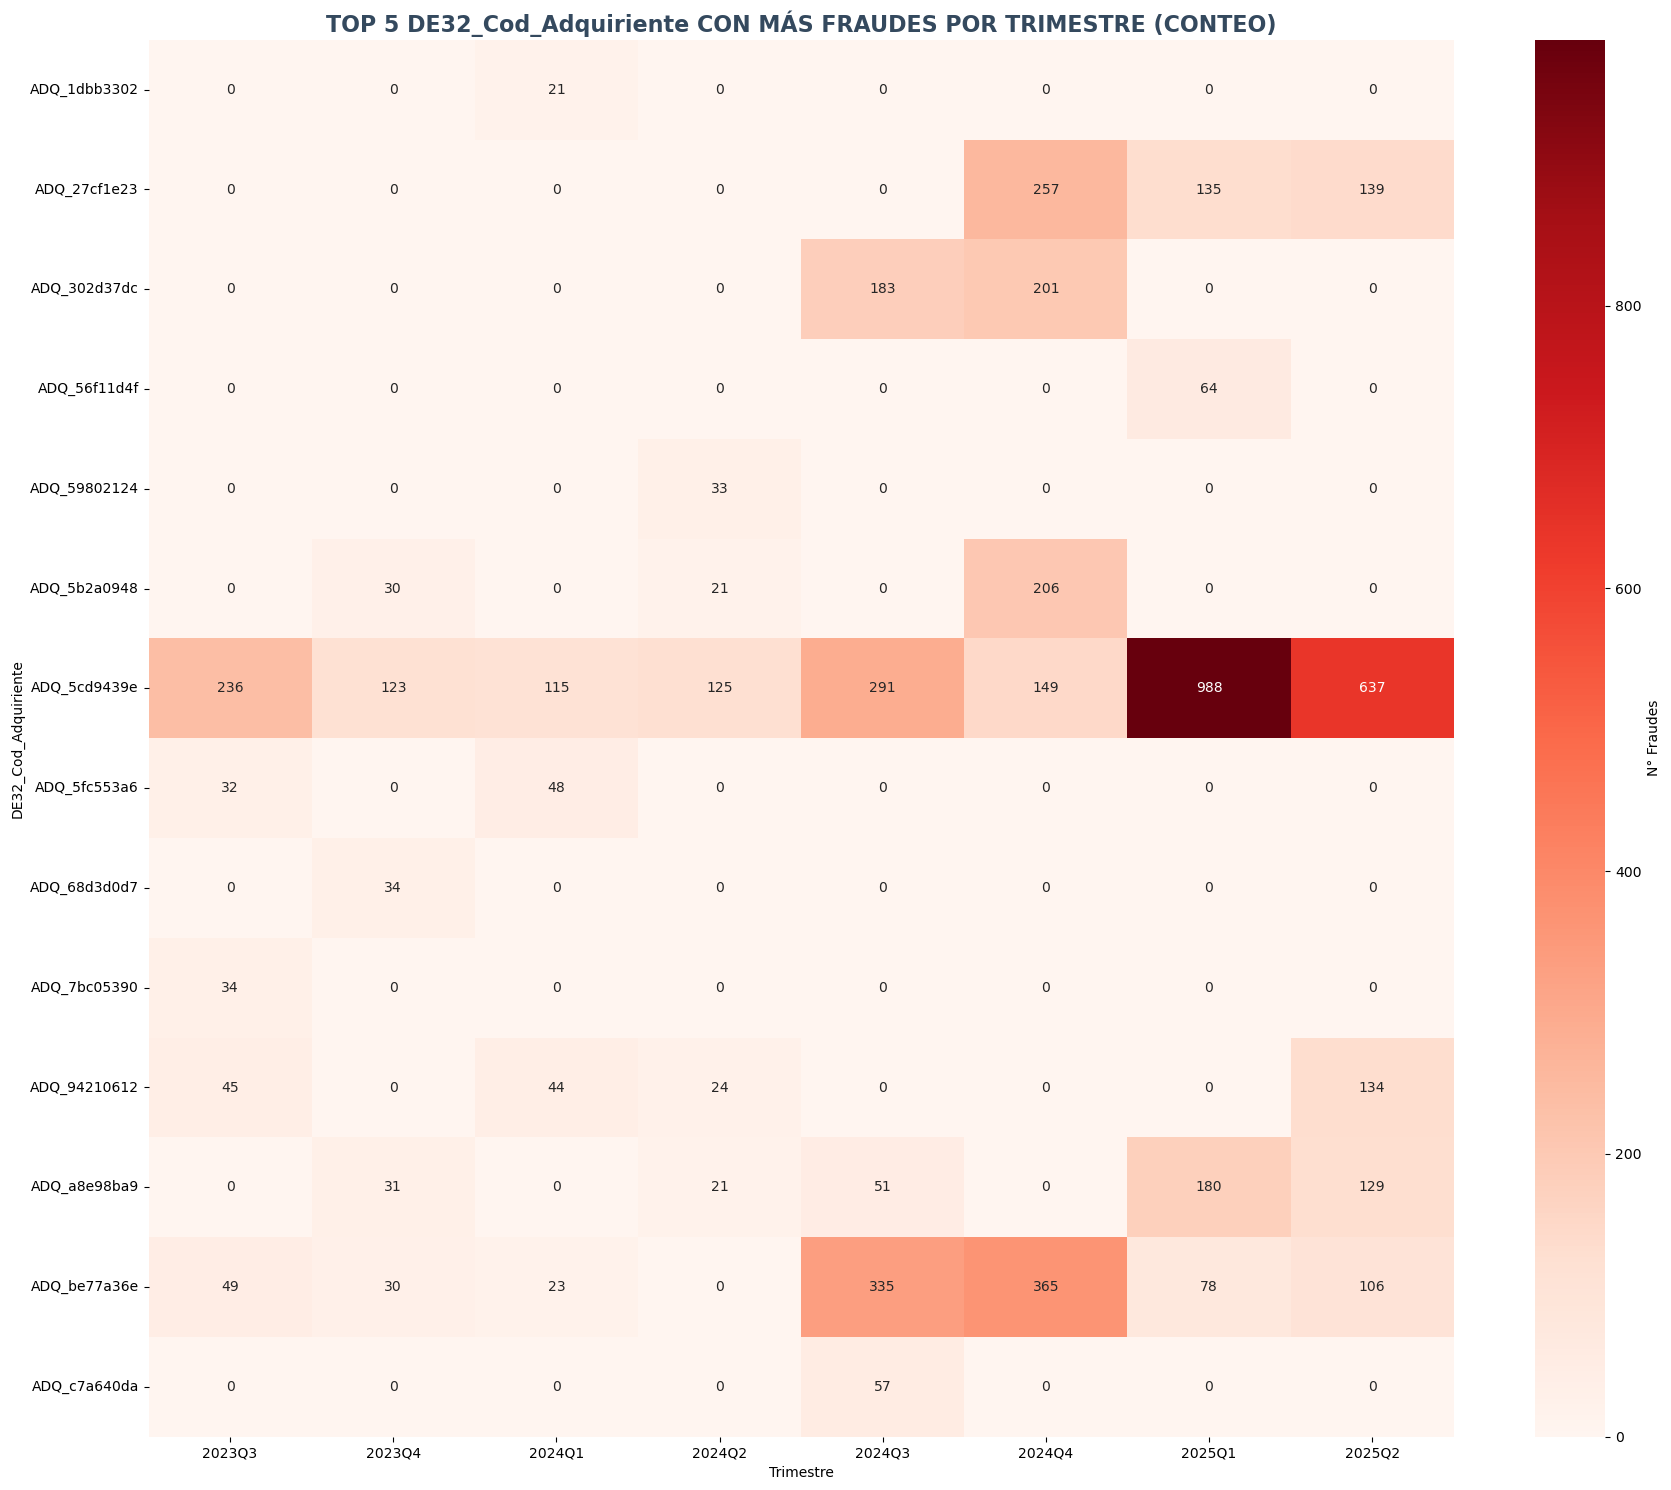

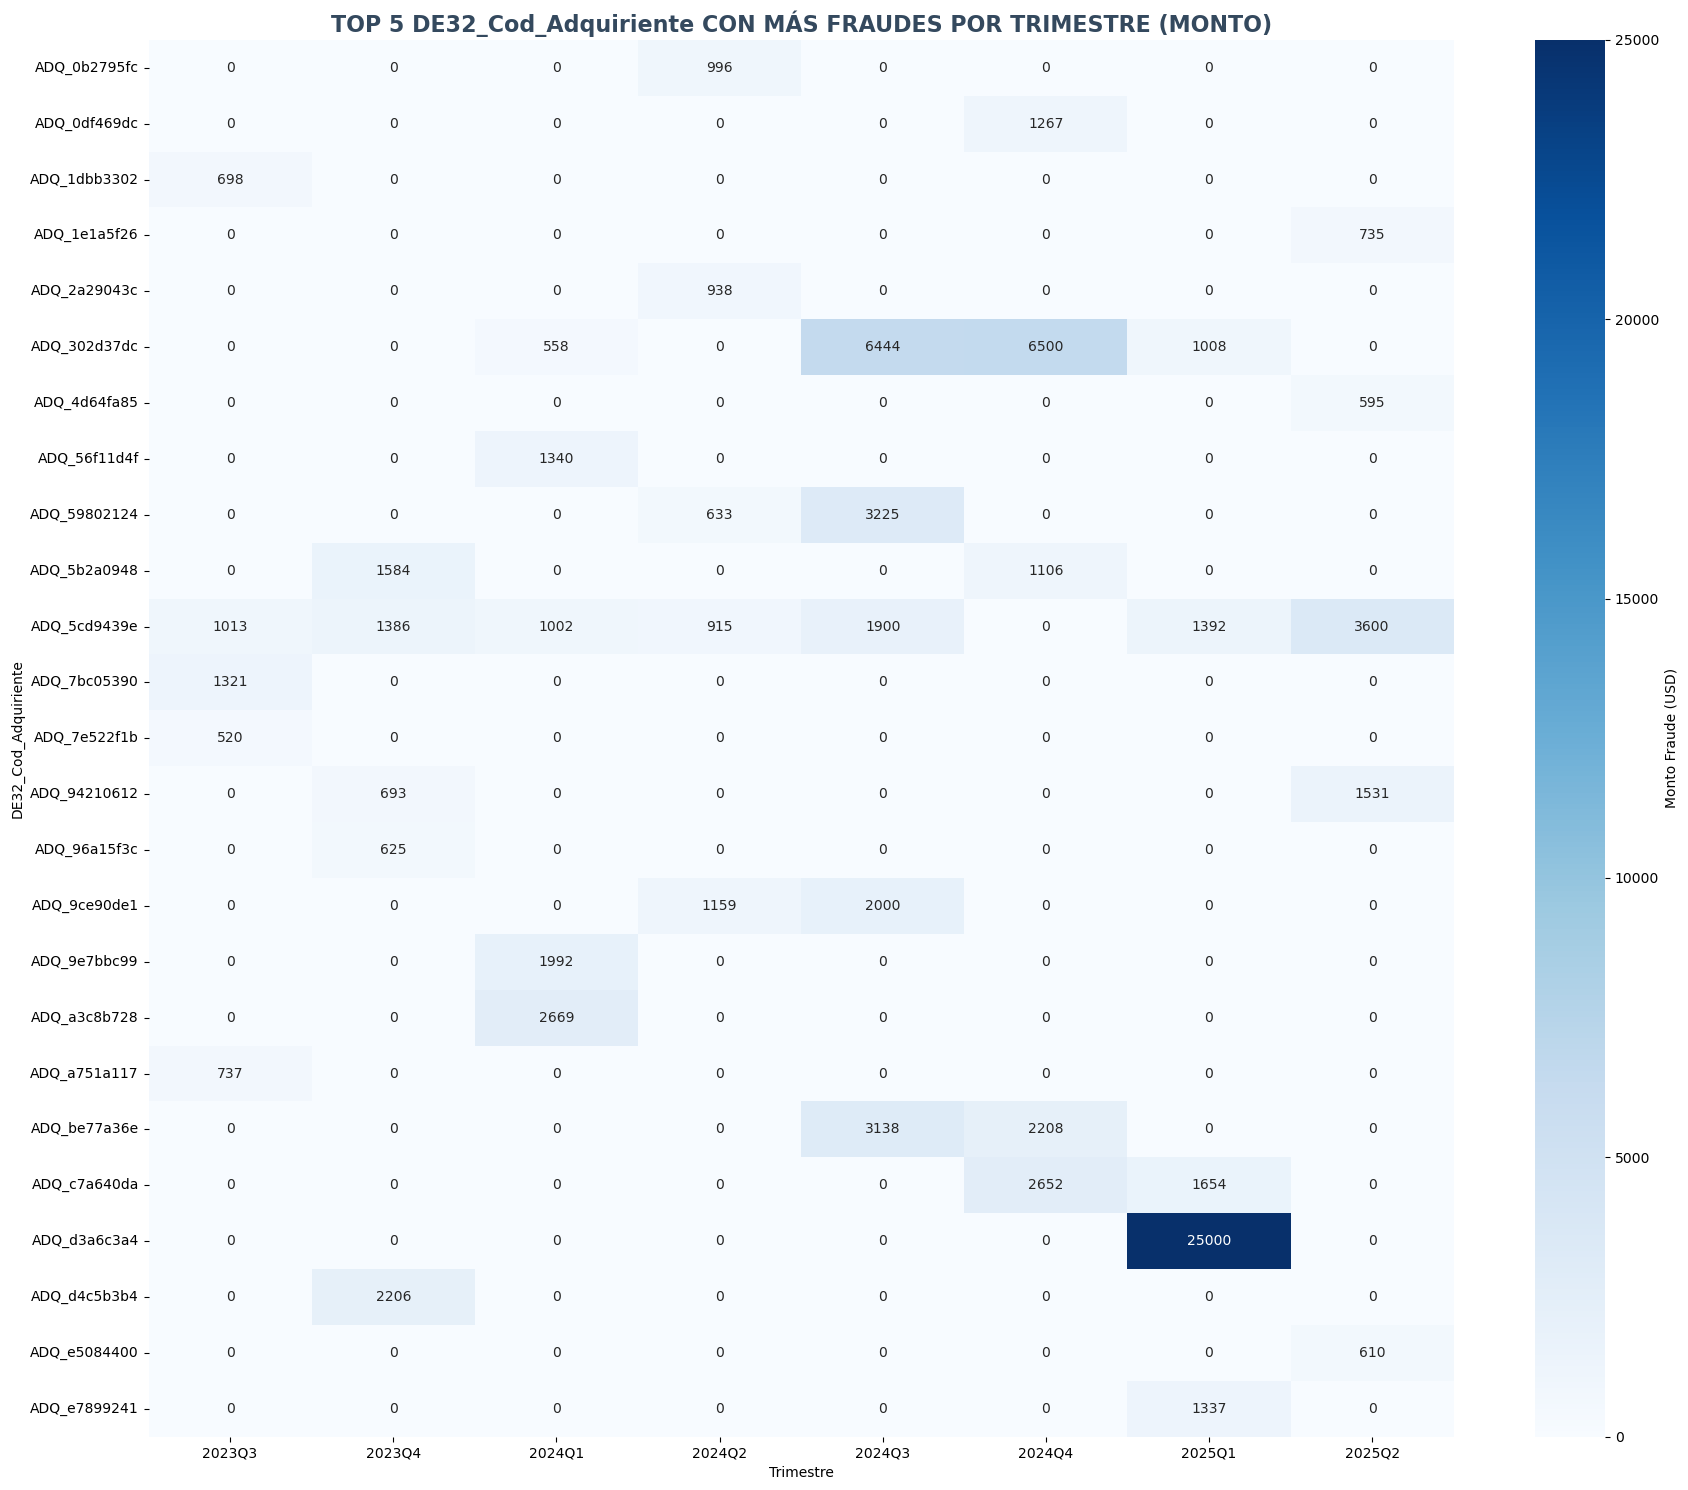

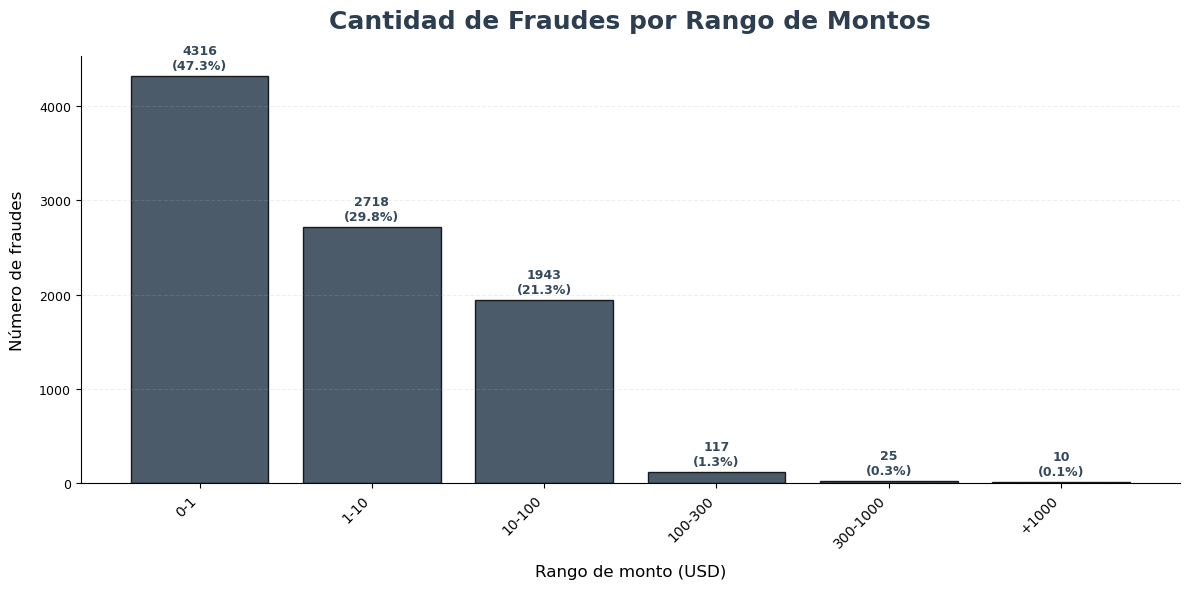

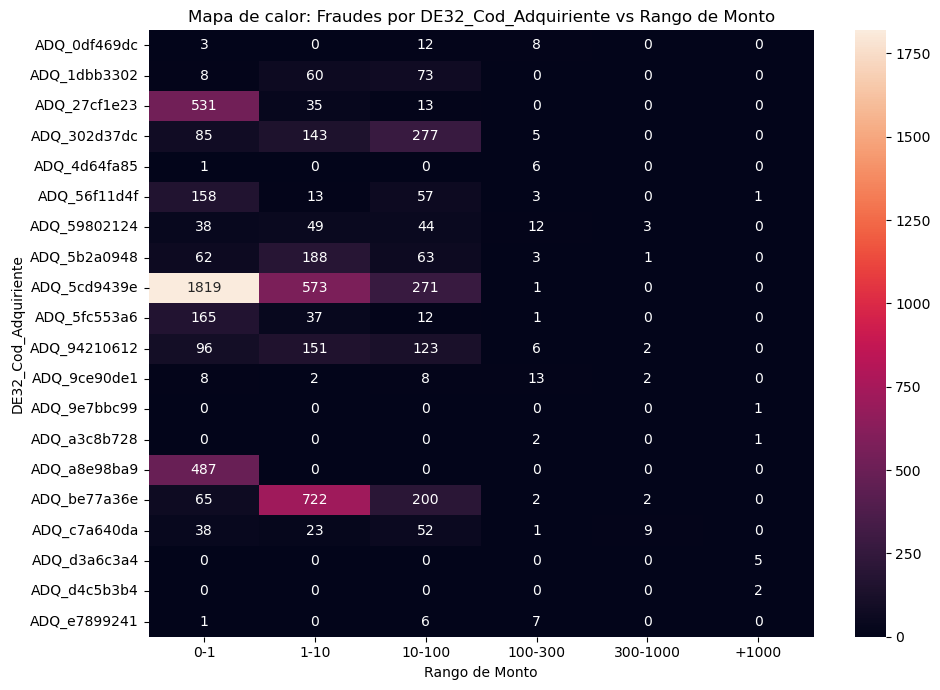

In [117]:
# CAMPO objetivo para el análisis: cambia solo esta variable
CAMPO_PRIMARIO = "DE32_Cod_Adquiriente"  

TOP_N = 5  # cantidad top por reporte

# ---- Conteo de transacciones fraudulentas ----
pivot_conteo = pd.pivot_table(
    df_patrones_fraudes_f,
    values='Id_Trx',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='count',
    fill_value=0
)
pivot_conteo['TOTAL'] = pivot_conteo.sum(axis=1)
pivot_conteo_sorted = pivot_conteo.sort_values(by='TOTAL', ascending=False)

# ---- Monto total de fraude por CAMPO ----
pivot_monto = pd.pivot_table(
    df_patrones_fraudes_f,
    values='DE6_Monto_Dolar',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)
pivot_monto['TOTAL'] = pivot_monto.sum(axis=1)
pivot_monto_sorted = pivot_monto.sort_values(by='TOTAL', ascending=False).round(1)

# ---- Heatmaps ----
plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_conteo_sorted.head(20),  # Mostrar top 
    annot=True, fmt="d", cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
sns.heatmap(
    pivot_monto_sorted.head(20),  # Mostrar top 
    annot=True, fmt=".0f", cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupa fraudes por trimestre y campo ----
fraudes_trim = df_patrones_fraudes_f.groupby(['trimestre', CAMPO_PRIMARIO]).agg(
    fraudes=('Id_Trx', 'count'),
    monto_fraude=('DE6_Monto_Dolar', 'sum')
).reset_index()

# ---- Top CAMPO por trimestre (conteo fraudes) ----
top_conteo = (
    fraudes_trim.sort_values(['trimestre', 'fraudes'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_conteo = top_conteo.pivot_table(
    values='fraudes',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

# ---- Top CAMPO por trimestre (monto defraudado) ----
top_monto = (
    fraudes_trim.sort_values(['trimestre', 'monto_fraude'], ascending=[True, False])
    .groupby('trimestre')
    .head(TOP_N)
)
pivot_monto = top_monto.pivot_table(
    values='monto_fraude',
    index=CAMPO_PRIMARIO,
    columns='trimestre',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_conteo,
    annot=True,
    fmt="d",
    cmap="Reds",
    cbar_kws={'label': 'N° Fraudes'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (CONTEO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 15))
sns.heatmap(
    pivot_monto,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Monto Fraude (USD)'}
)
plt.title(f"TOP {TOP_N} {CAMPO_PRIMARIO} CON MÁS FRAUDES POR TRIMESTRE (MONTO)", fontsize=16, fontweight="bold", color="#34495e")
plt.xlabel("Trimestre")
plt.ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()

# ---- Agrupar por rangos de montos usando 'rango_monto' ----
fraude_por_rango = (
    df_patrones_fraudes_f.groupby("rango_monto", observed=True)
    .agg(
        Total_Transacciones=("Fraude", "size"),
        Total_Fraudes=("Fraude", "sum"),
        Monto_Fraude_Total=("DE6_Monto_Dolar", "sum")
    ).reset_index()
)

plt.figure(figsize=(12,6))
ax = plt.bar(
    fraude_por_rango["rango_monto"], 
    fraude_por_rango["Total_Fraudes"], 
    color="#2c3e50", 
    edgecolor="black", 
    alpha=0.85
)
plt.title("Cantidad de Fraudes por Rango de Montos", fontsize=18, fontweight="bold", color="#2c3e50", pad=20)
plt.xlabel("Rango de monto (USD)", fontsize=12, labelpad=10)
plt.ylabel("Número de fraudes", fontsize=12, labelpad=10)
plt.grid(axis="y", alpha=0.2, linestyle="--")
total_fraudes = fraude_por_rango["Total_Fraudes"].sum()
porc_fraudes = (fraude_por_rango["Total_Fraudes"] / total_fraudes * 100).round(2)
for i, (valor, pct) in enumerate(zip(fraude_por_rango["Total_Fraudes"], porc_fraudes)):
    plt.text(
        i, 
        valor + (max(fraude_por_rango["Total_Fraudes"]) * 0.01),
        f"{valor}\n({pct:.1f}%)", 
        ha="center", va="bottom", fontsize=9, fontweight="bold", color="#34495e"
    )
ax = plt.gca()
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis="y", labelsize=9)
plt.tight_layout()
plt.show()

# ---- Top por rango por CAMPO objetivo ----
top_por_rango = (
    df_patrones_fraudes_f
    .groupby(["rango_monto", CAMPO_PRIMARIO], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
)
top_por_rango[CAMPO_PRIMARIO] = top_por_rango[CAMPO_PRIMARIO].astype(str)
top_por_rango = (
    top_por_rango
    .sort_values(["rango_monto", "Total_Fraudes"], ascending=[True, False])
    .groupby("rango_monto", observed=True)
    .head(TOP_N)
    .reset_index(drop=True)
)
top_union = sorted(top_por_rango[CAMPO_PRIMARIO].unique())

heat_df = (
    df_patrones_fraudes_f
    .assign(hash_campo=df_patrones_fraudes_f[CAMPO_PRIMARIO].astype(str))
    .groupby([CAMPO_PRIMARIO, "rango_monto"], observed=True)
    .size()
    .reset_index(name="Total_Fraudes")
    .query(f"{CAMPO_PRIMARIO} in @top_union")
)
heat_pivot = (
    heat_df
    .pivot(index=CAMPO_PRIMARIO, columns="rango_monto", values="Total_Fraudes")
    .fillna(0)
    .astype(int)
    .reindex(index=top_union)
)

plt.figure(figsize=(10, max(6, len(top_union) * 0.35)))
ax = sns.heatmap(
    heat_pivot,
    annot=True, fmt="d",
)
ax.set_title(f"Mapa de calor: Fraudes por {CAMPO_PRIMARIO} vs Rango de Monto")
ax.set_xlabel("Rango de Monto")
ax.set_ylabel(CAMPO_PRIMARIO)
plt.tight_layout()
plt.show()